In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import statsmodels.formula.api as smf
from scipy import stats

plt.style.use('seaborn-v0_8-poster')


In [2]:
def significance_marker(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""


def _draw_sig_line(ax, x1, x2, y, text, h=0.03):
    """Draw a flipped (downward) significance bracket below bars."""
    ax.plot((x1, x1, x2, x2),
            (y, y - h, y - h, y),
            lw=1.5, color="black", clip_on=False)
    if text:
        ax.text((x1 + x2) / 2.0, y - h * 1.2, text,
                ha="center", va="top",
                fontsize=14, fontweight="bold", color="black")


def get_matching_model_terms(model, variable):
    """
    Return model term names from model.params.index that match `variable`.

    Behavior:
    ----------
    - If `variable` has no ':' or '*' → return only main-effect terms
      (e.g., 'Group' → ['Group[T.HC]'])
    - If `variable` includes ':' or '*' → return exact interaction terms
      (e.g., 'Group:Drug' → ['Group[T.HC]:Drug[T.Placebo]'])
    - If `variable` == 'two_way' → return *all* 2-way interactions
      (useful in 3-factor models like Group * Drug * Gender)
    - If `variable` == 'three_way' → return *all* 3-way interactions

    Example model.params.index:
      ['Intercept',
       'Group[T.HC]',
       'Drug[T.Placebo]',
       'Gender[T.Female]',
       'Group[T.HC]:Drug[T.Placebo]',
       'Group[T.HC]:Gender[T.Female]',
       'Drug[T.Placebo]:Gender[T.Female]',
       'Group[T.HC]:Drug[T.Placebo]:Gender[T.Female]']
    """
    # Remove intercept
    params = [p for p in model.params.index if p.lower() != "intercept"]

    # === Case 1: Request all 2-way interactions ===
    if variable.lower() == "two_way":
        return [p for p in params if p.count(":") == 1]

    # === Case 2: Request all 3-way interactions ===
    if variable.lower() == "three_way":
        return [p for p in params if p.count(":") == 2]

    # === Case 3: Single factor → main effects only ===
    if (":" not in variable) and ("*" not in variable):
        factor = variable
        return [p for p in params if p.startswith(factor + "[") and (":" not in p)]

    # === Case 4: Specific interaction (2-way or 3-way) ===
    var = variable.replace("*", ":")
    factors = [f for f in var.split(":") if f]

    out = []
    for p in params:
        # must have correct interaction order
        if p.count(":") != (len(factors) - 1):
            continue
        # must include all specified factors
        if all((f + "[") in p for f in factors):
            out.append(p)

    return out



def extract_factors_from_term(term):
    """
    Extract base factor names (e.g., 'Group', 'Drug', 'Gender') 
    from a statsmodels term like:
        'Group[T.HC]:Drug[T.Placebo]'  → ['Group', 'Drug']
        'Group[T.HC]:Drug[T.Placebo]:Gender[T.Female]' → ['Group', 'Drug', 'Gender']
        'Group[T.HC]' → ['Group']

    Works for both main and interaction terms.
    """
    # Split by ':' to separate interaction components
    parts = term.split(":")
    # For each part, take everything before the first '['
    factors = [p.split("[")[0] for p in parts]
    return factors

In [3]:
def add_sig_stars(ax, df, roi_list, variable, pad_frac=0.1, hue_order=None):
    """
    Generalized version that supports 2-way, 3-way, or higher-order interactions.

    Prints:
      1. Model result (ROI, variable, β, t, df, p)
      2. One-sample t-tests (ROI, factor level, mean, t, df, p)
    Adds * to bar plot for significant results.

    Automatically reads model factors from 'variable'.
    e.g. variable='Group[T.HC]:Drug[T.Placebo]:Gender[T.Female]' → model='Z_score ~ Group * Drug * Gender'
    """

    ymin, ymax = ax.get_ylim()
    y_range = ymax - ymin
    is_interaction = ":" in variable

    # === Parse model factors dynamically ===
    # Example: 'Group[T.HC]:Drug[T.Placebo]:Gender[T.Female]' → ['Group', 'Drug', 'Gender']
    factors = list(dict.fromkeys([term.split("[")[0] for term in variable.split(":")]))
    formula = "Z_score ~ " + " * ".join(factors) + ("" if "guess" in factors else " + guess")


    print(f"\nModel results ({formula})")
    print(f"{'ROI':<15} {'Variable':<50} {'β':>10} {'t':>8} {'df':>5} {'p':>8} {'Sig':>5}")
    print("-" * 100)

    # === Table 1: Model results ===
    for i, roi in enumerate(roi_list):
        df_roi = df[df["ROI"] == roi]
        if len(df_roi) < 4:
            continue

        # 🔹 Dynamically specified model
        model = smf.ols(formula, data=df_roi).fit()

        if variable not in model.params.index:
            continue

        beta = model.params[variable]
        tval = model.tvalues[variable]
        pval = model.pvalues[variable]
        dfree = int(model.df_resid)
        star = significance_marker(pval)

        print(f"{roi:<15} {variable:<50} {beta:>10.3f} {tval:>8.2f} {dfree:>5} {pval:>8.3f} {star:>5}")

        # --- Bar selection per ROI ---
        bars = [r for r in ax.patches if abs((r.get_x() + r.get_width() / 2) - i) < 0.45]
        if not bars:
            continue

        # --- Draw flipped bracket for significant model effects (main effects only) ---
        if not is_interaction and star:
            bars_sorted = sorted(bars, key=lambda r: r.get_x())
            b1, b2 = bars_sorted[0], bars_sorted[-1]
            x1c = b1.get_x() + b1.get_width() / 2
            x2c = b2.get_x() + b2.get_width() / 2
            x_mid = (x1c + x2c) / 2
            y1 = b1.get_y() + b1.get_height()
            y2 = b2.get_y() + b2.get_height()
            min_y = min(y1, y2)
            y_bracket = min_y - 0.3
            y_star = min_y - 0.4
            _draw_sig_line(ax, x1c, x2c, y_bracket, "", h=y_range * 0.03)
            ax.text(x_mid, y_star, star,
                    ha="center", va="top",
                    fontsize=14, fontweight="bold", color="black")

    print("-" * 100)

    # === Table 2: One-sample t-tests ===
    if is_interaction:
        group_factors = factors
        print(f"ONE-SAMPLE T-TESTS BY INTERACTION LEVEL ({' × '.join(group_factors)})")
    else:
        group_factors = [factors[0]]
        print(f"ONE-SAMPLE T-TESTS BY {group_factors[0].upper()} LEVEL")

    print(f"{'ROI':<15} {'Level':<50} {'Mean':>10} {'t':>8} {'df':>6} {'p':>10} {'Sig':>5}")
    print("-" * 100)

    for i, roi in enumerate(roi_list):
        df_roi = df[df["ROI"] == roi]
        if len(df_roi) < 4:
            continue

        bars = [r for r in ax.patches if abs((r.get_x() + r.get_width() / 2) - i) < 0.45]

        # === Main effect ===
        if len(group_factors) == 1:
            factor = group_factors[0]
            if factor not in df_roi.columns:
                continue

            for level, vals in df_roi.groupby(factor, observed=False):
                if len(vals) < 3:
                    continue
                tstat, pval = stats.ttest_1samp(vals["Z_score"], 0)
                dfree = len(vals) - 1
                mean_val = np.mean(vals["Z_score"])
                star = significance_marker(pval)
                label = f"{factor}={level}"
                print(f"{roi:<15} {label:<50} {mean_val:>10.3f} {tstat:>8.2f} {dfree:>6} {pval:>10.3f} {star:>5}")

                if star:
                    if hue_order is None:
                        hue_order = list(df[factor].cat.categories)
                    level_to_bar = dict(zip(hue_order, bars))
                    if level in level_to_bar:
                        rect = level_to_bar[level]
                        cx = rect.get_x() + rect.get_width() / 2
                        top = rect.get_y() + rect.get_height()
                        y_star = 0.04 if mean_val <= 0 else top + y_range * pad_frac + 0.2
                        ax.text(cx, y_star, star,
                                ha="center", va="bottom",
                                fontsize=14, fontweight="bold", color="black")

        # === Interaction effect (2-way, 3-way, or higher) ===
        else:
            valid_factors = [f for f in group_factors if f in df_roi.columns]
            if len(valid_factors) < 2:
                continue

            for levels, vals in df_roi.groupby(valid_factors, observed=False):
                if len(vals) < 3:
                    continue
                tstat, pval = stats.ttest_1samp(vals["Z_score"], 0)
                dfree = len(vals) - 1
                mean_val = np.mean(vals["Z_score"])
                star = significance_marker(pval)
                level_labels = "_".join(map(str, levels))
                print(f"{roi:<15} {level_labels:<50} {mean_val:>10.3f} "
                      f"{tstat:>8.2f} {dfree:>6} {pval:>10.3f} {star:>5}")

                if star:
                    # Build hue order dynamically based on unique combinations
                    if hue_order is None:
                        hue_order = [
                            "_".join(map(str, combo))
                            for combo in df_roi[valid_factors]
                            .drop_duplicates()
                            .itertuples(index=False, name=None)
                        ]
                    level_to_bar = dict(zip(hue_order, bars))
                    key = "_".join(map(str, levels))
                    if key in level_to_bar:
                        rect = level_to_bar[key]
                        cx = rect.get_x() + rect.get_width() / 2
                        top = rect.get_y() + rect.get_height()
                        y_star = 0.04 if mean_val <= 0 else top + y_range * pad_frac + 0.2
                        ax.text(cx, y_star, star,
                                ha="center", va="bottom",
                                fontsize=14, fontweight="bold", color="black")

    print("-" * 100)


In [4]:
def add_sig_stars_lineplot_interaction(ax, df, roi_list, variable):
    """
    Adds significance stars (***, **, *) to each subplot's title
    if the specified interaction term in `variable` is significant
    for that ROI.

    Automatically supports 2-way, 3-way, or higher-order interactions.
    e.g.:
        'Group[T.HC]:Gender[T.Female]'
        'Group[T.HC]:Drug[T.Placebo]:Gender[T.Female]'
    """

    # Extract main factors from variable (remove duplicates safely)
    factors = list(dict.fromkeys([term.split("[")[0] for term in variable.split(":")]))
    formula = "Z_score ~ " + " * ".join(factors) + ("" if "guess" in factors else " + guess")

    axes = ax.flat if hasattr(ax, "flat") else [ax]

    print(f"\n=== Lineplot significance check for {variable} ===")
    print(f"Model formula: {formula}")
    print(f"{'ROI':<15} {'p-value':>10} {'Sig':>5}")
    print("-" * 35)

    for i, roi in enumerate(roi_list):
        if i >= len(axes):
            break
        ax_i = axes[i]

        df_roi = df[df["ROI"] == roi]
        if len(df_roi) < 4:
            continue

        # Dynamically fit model with all relevant factors
        model = smf.ols(formula, data=df_roi).fit()

        # Skip if the term is not part of the model
        if variable not in model.pvalues.index:
            continue

        # Get p-value and significance marker
        pval = model.pvalues[variable]
        star = significance_marker(pval)

        # Update subplot title with star if significant
        current_title = ax_i.get_title()
        new_title = f"{current_title} {star}" if star else current_title
        ax_i.set_title(new_title, fontweight="bold" if star else "normal")

        print(f"{roi:<15} {pval:>10.4f} {star:>5}")

    print("-" * 35)


In [5]:
tasks = ['phase2','phase3']
contrast_list = [
        "CSR-CSS",   
        "CSR-CS-",
        "CSS-CS-",
        "CSR-fix", 
        "CSS-fix",   
        "CSminus-fix"
        ]
ROI_list = [
        'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
        'VMPFC'
        ]
group_list = [
        'Patient',
        'HC'
        ]
drug_list = ['Oxytocin',
        'Placebo']
gender_list = ['Male', 'Female']

In [6]:
plot_dir_top = '/Users/xiaoqianxiao/Projects/NARSAD/MRI/derivatives/fMRI_analysis/ROI/plots/model-guess_motion-removeFD0.5'
drug_order_file = '/Users/xiaoqianxiao/Projects/NARSAD/MRI/source_data/behav/drug_order.xlsx'
df_drug_order = pd.read_excel(drug_order_file, 'drug_order')
first_level_dir = '/Users/xiaoqianxiao/Projects/NARSAD/MRI/derivatives/fMRI_analysis/ROI'
first_level_data_file = os.path.join(first_level_dir, 'first_level_motion-removeFD0.5.csv')
df_fMRI = pd.read_csv(first_level_data_file)
df_merged = pd.merge(df_fMRI, df_drug_order, on='subID', how='left')
df_all = df_merged.rename(columns={
    'Task': 'Phase'
})
df_all.loc[df_all['subID'].str.startswith('N1'), 'Group'] = 'Patient'
df_all.loc[df_all['subID'].str.startswith('N2'), 'Group'] = 'HC'
categorical_cols = ['ROI', 'subID', 'Phase', 'Contrast', 'Group', 'Gender', 'Drug','guess']
df_all[categorical_cols] = df_all[categorical_cols].astype('category')
df_all['Contrast'] = df_all['Contrast'].cat.set_categories(contrast_list, ordered=True)
df_all['ROI'] = df_all['ROI'].cat.set_categories(ROI_list, ordered=True)
df_all['Group'] = df_all['Group'].cat.set_categories(group_list, ordered=True)
df_all['Drug'] = df_all['Drug'].cat.set_categories(drug_list, ordered=True)
df_all['Gender'] = df_all['Gender'].cat.set_categories(gender_list, ordered=True)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/xiaoqianxiao/Projects/NARSAD/MRI/derivatives/fMRI_analysis/ROI/first_level_motion-removeFD0.5.csv'

In [ ]:
print(len(df_fMRI.loc[df_fMRI['Task']=='phase2']['subID'].unique()))
print(len(df_fMRI.loc[df_fMRI['Task']=='phase3']['subID'].unique()))
print(len(df_drug_order['subID'].unique()))

100
101
104


In [ ]:
# Subjects in drug order but missing from fMRI data
missing_in_fMRI = df_drug_order.loc[
    ~df_drug_order['subID'].isin(df_fMRI.loc[df_fMRI['Task']=='phase2']['subID']), 'subID'
].unique()

print(f"🧩 Subjects in drug order file but not in fMRI data in phase2: {len(missing_in_fMRI)}")
print(missing_in_fMRI)

missing_in_fMRI = df_drug_order.loc[
    ~df_drug_order['subID'].isin(df_fMRI.loc[df_fMRI['Task']=='phase3']['subID']), 'subID'
].unique()

print(f"🧩 Subjects in drug order file but not in fMRI data in phase3: {len(missing_in_fMRI)}")
print(missing_in_fMRI)
# SUBJECTS_NO_MRI = {
#     'phase2': ['N102', 'N208'],
#     'phase3': ['N102', 'N208', 'N120']
# }
# removing subjects w wrong sequence / missing phases:
# sub101 has 2mm seq for phase 2, 3mm (correct) for phase 3
# sub201, has 2mm seq for phase 2, 3mm (correct) for phase 3



🧩 Subjects in drug order file but not in fMRI data in phase2: 4
['N101' 'N102' 'N201' 'N208']
🧩 Subjects in drug order file but not in fMRI data in phase3: 3
['N102' 'N120' 'N208']


Extinction

placebo 

In [ ]:
plot_dir = os.path.join(plot_dir_top, 'extinction/placebo')
os.makedirs(plot_dir, exist_ok=True)
model = smf.ols("Z_score ~ Group * Gender", data=df_all).fit()


===== Group main effect: CSR-CSS =====

Model results (Z_score ~ Group + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                             0.485     1.52    46    0.135      
Insula          Group[T.HC]                                             0.469     1.34    46    0.186      
Hippocampus     Group[T.HC]                                             0.332     0.87    46    0.386      
ACC             Group[T.HC]                                             0.289     0.86    46    0.396      
VMPFC           Group[T.HC]                                            -0.056    -0.16    46    0.873      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GROUP LEVEL
ROI             Level              

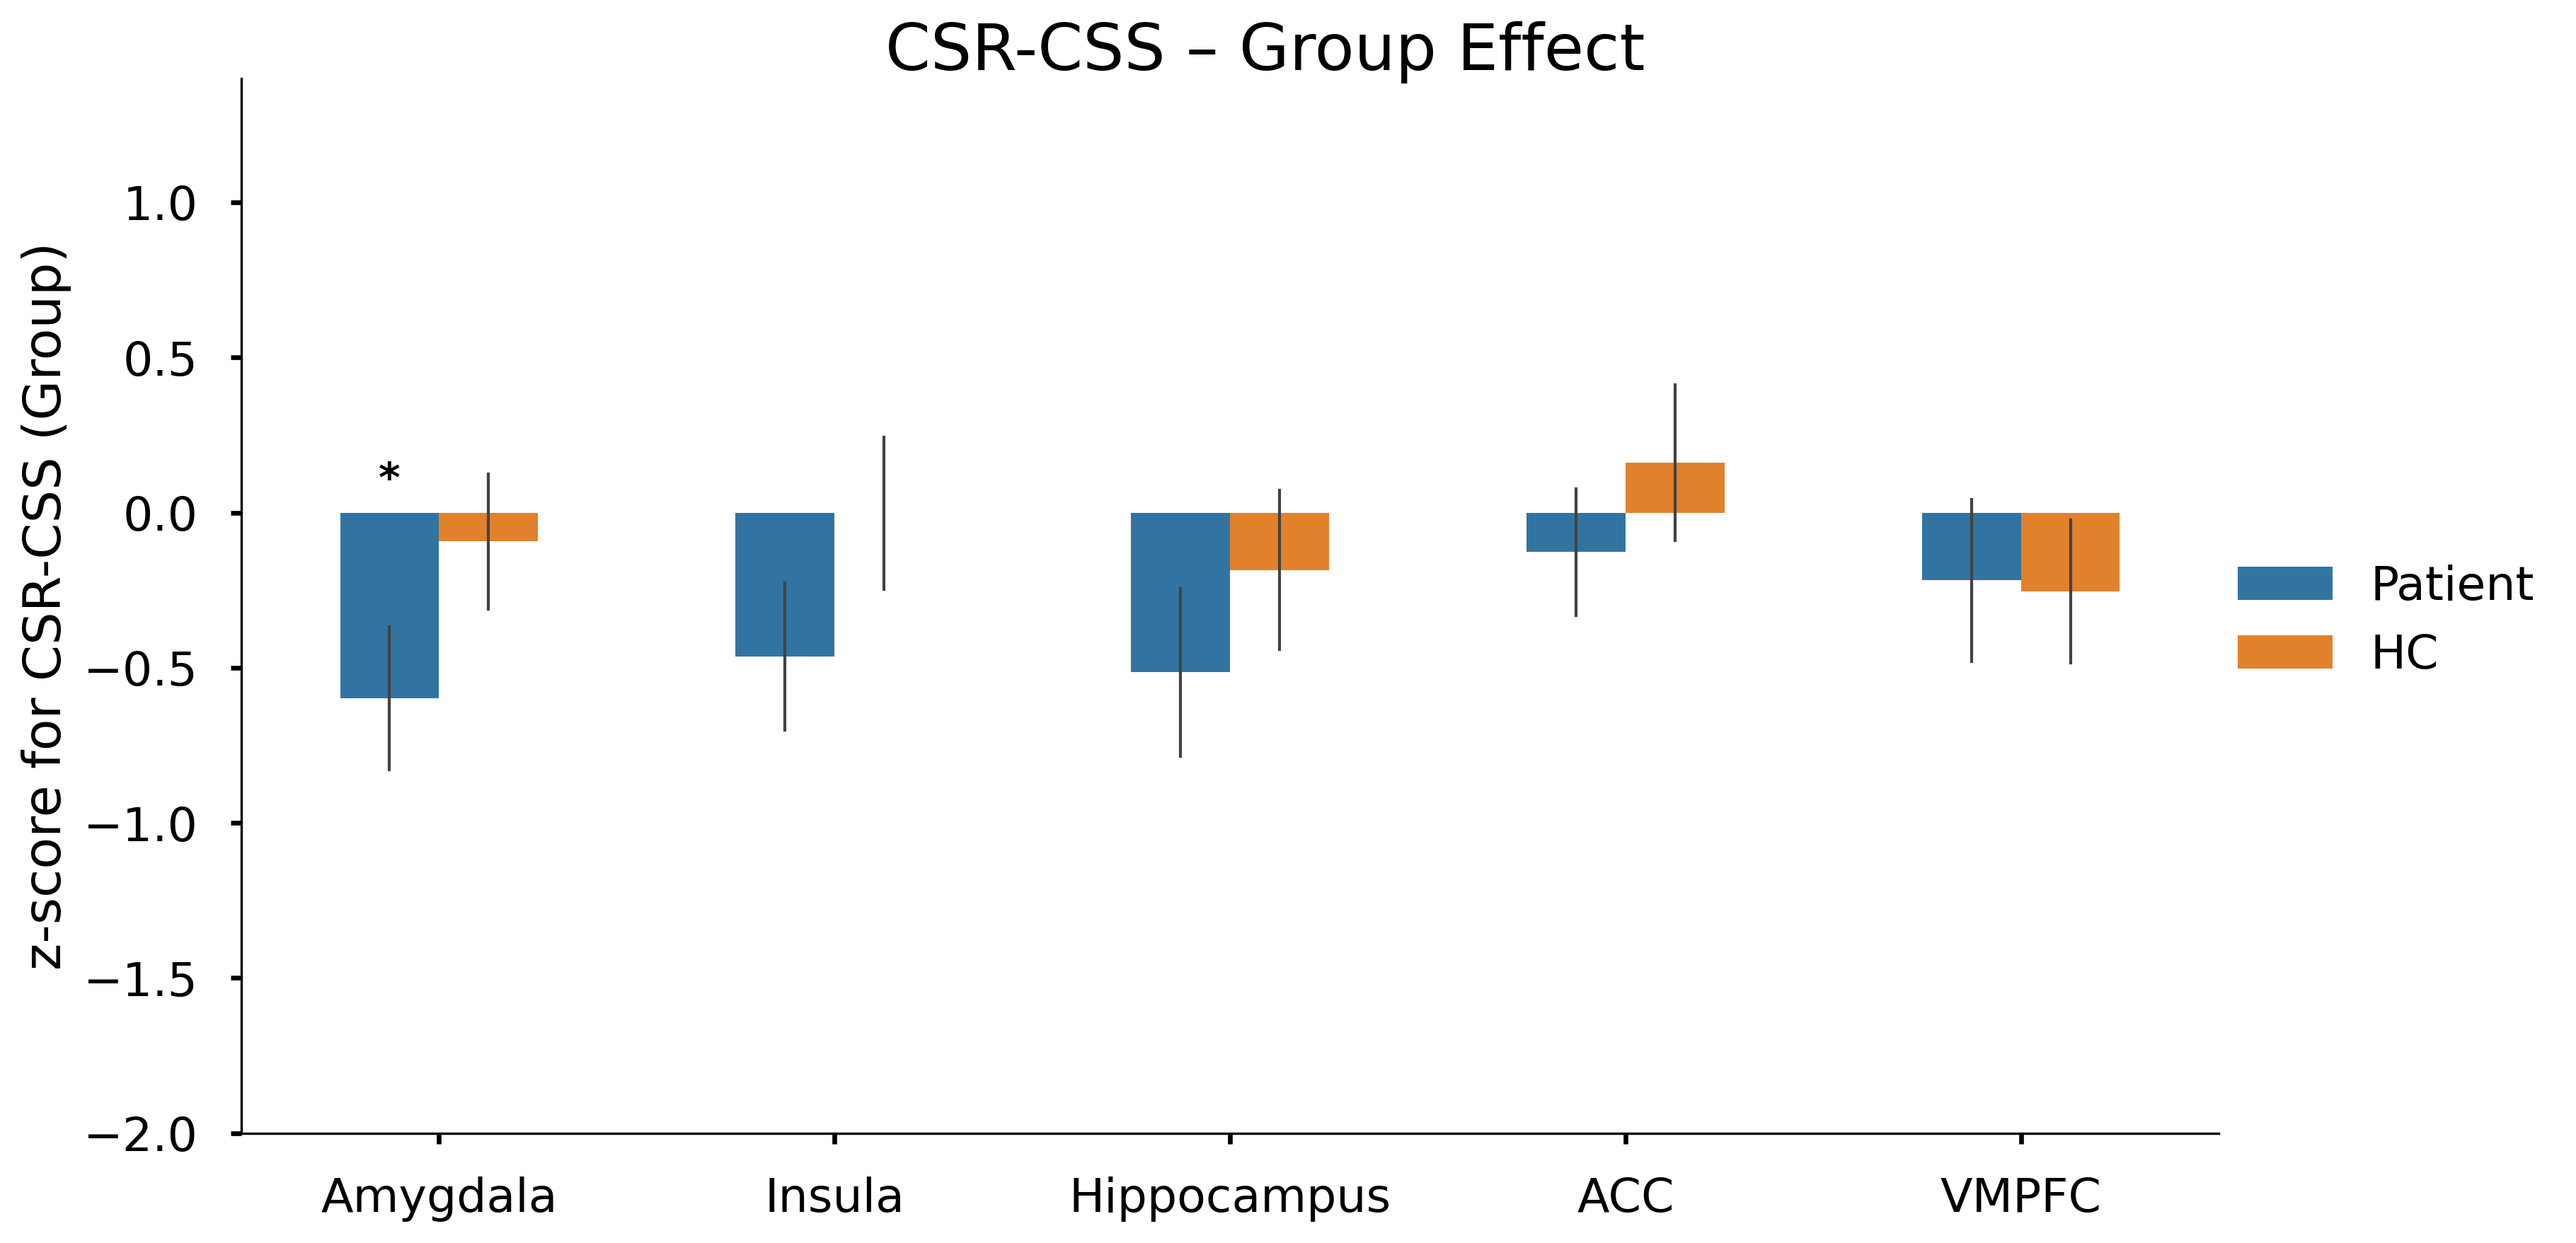


===== Group main effect: CSR-CS- =====

Model results (Z_score ~ Group + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                             0.344     1.05    46    0.297      
Insula          Group[T.HC]                                             0.566     1.52    46    0.135      
Hippocampus     Group[T.HC]                                             0.289     0.63    46    0.531      
ACC             Group[T.HC]                                             0.576     1.53    46    0.134      
VMPFC           Group[T.HC]                                             0.070     0.17    46    0.863      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GROUP LEVEL
ROI             Level              

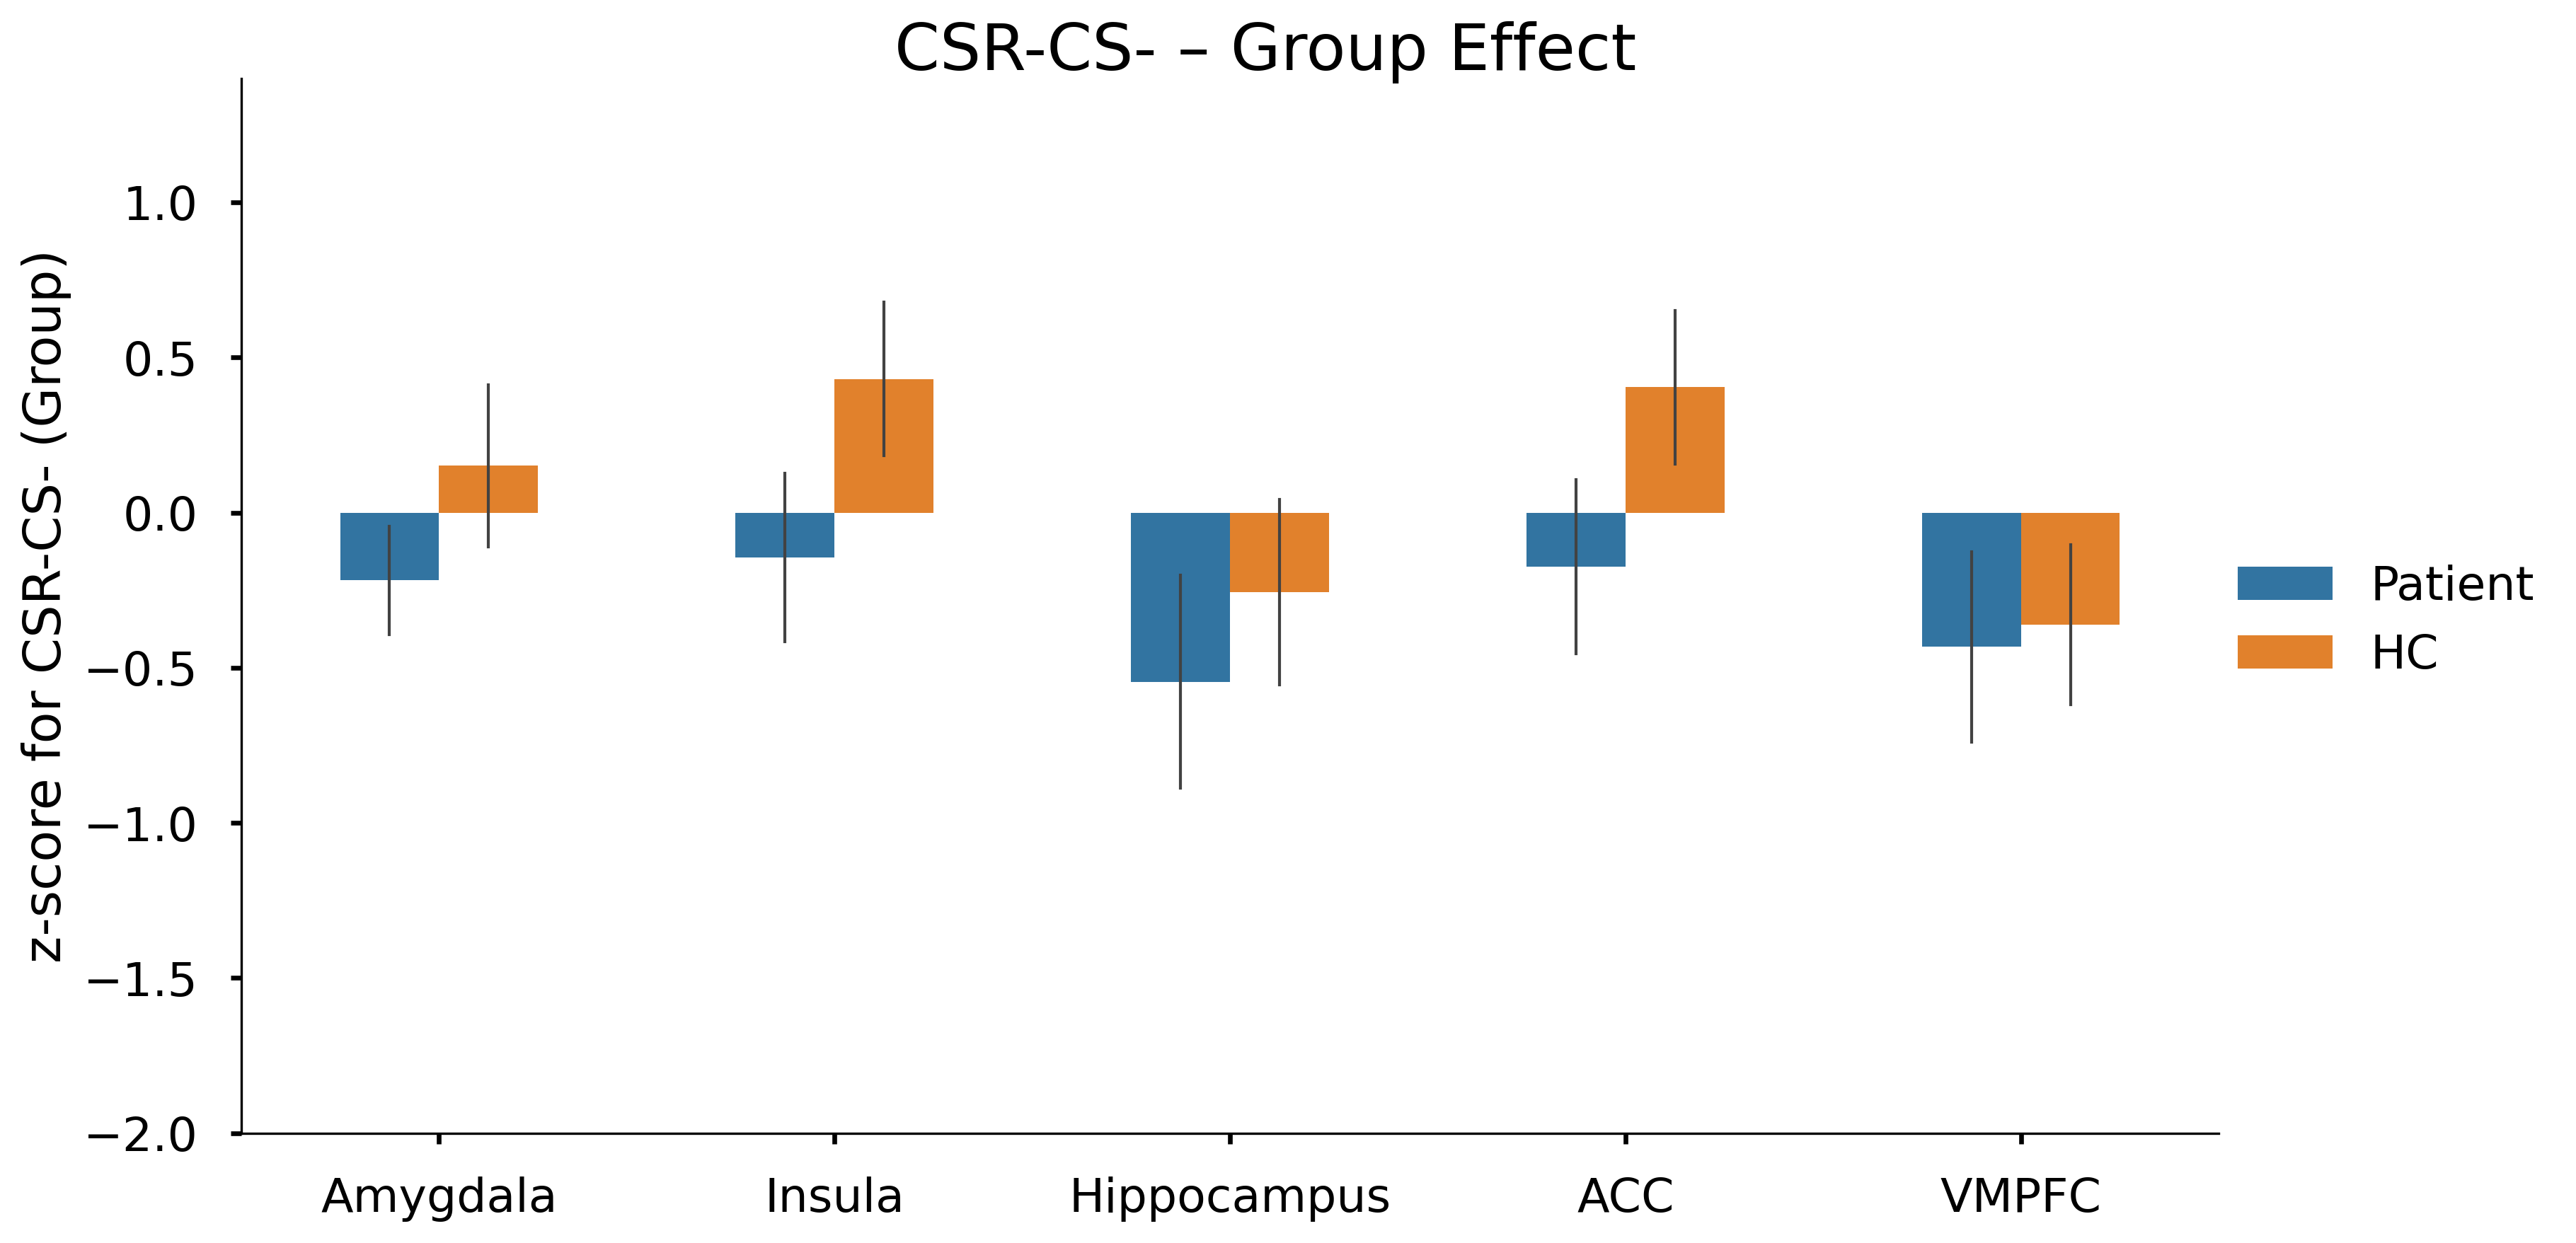


===== Group main effect: CSS-CS- =====

Model results (Z_score ~ Group + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                            -0.189    -0.56    46    0.577      
Insula          Group[T.HC]                                             0.054     0.14    46    0.891      
Hippocampus     Group[T.HC]                                            -0.078    -0.21    46    0.836      
ACC             Group[T.HC]                                             0.259     0.69    46    0.494      
VMPFC           Group[T.HC]                                             0.128     0.29    46    0.770      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GROUP LEVEL
ROI             Level              

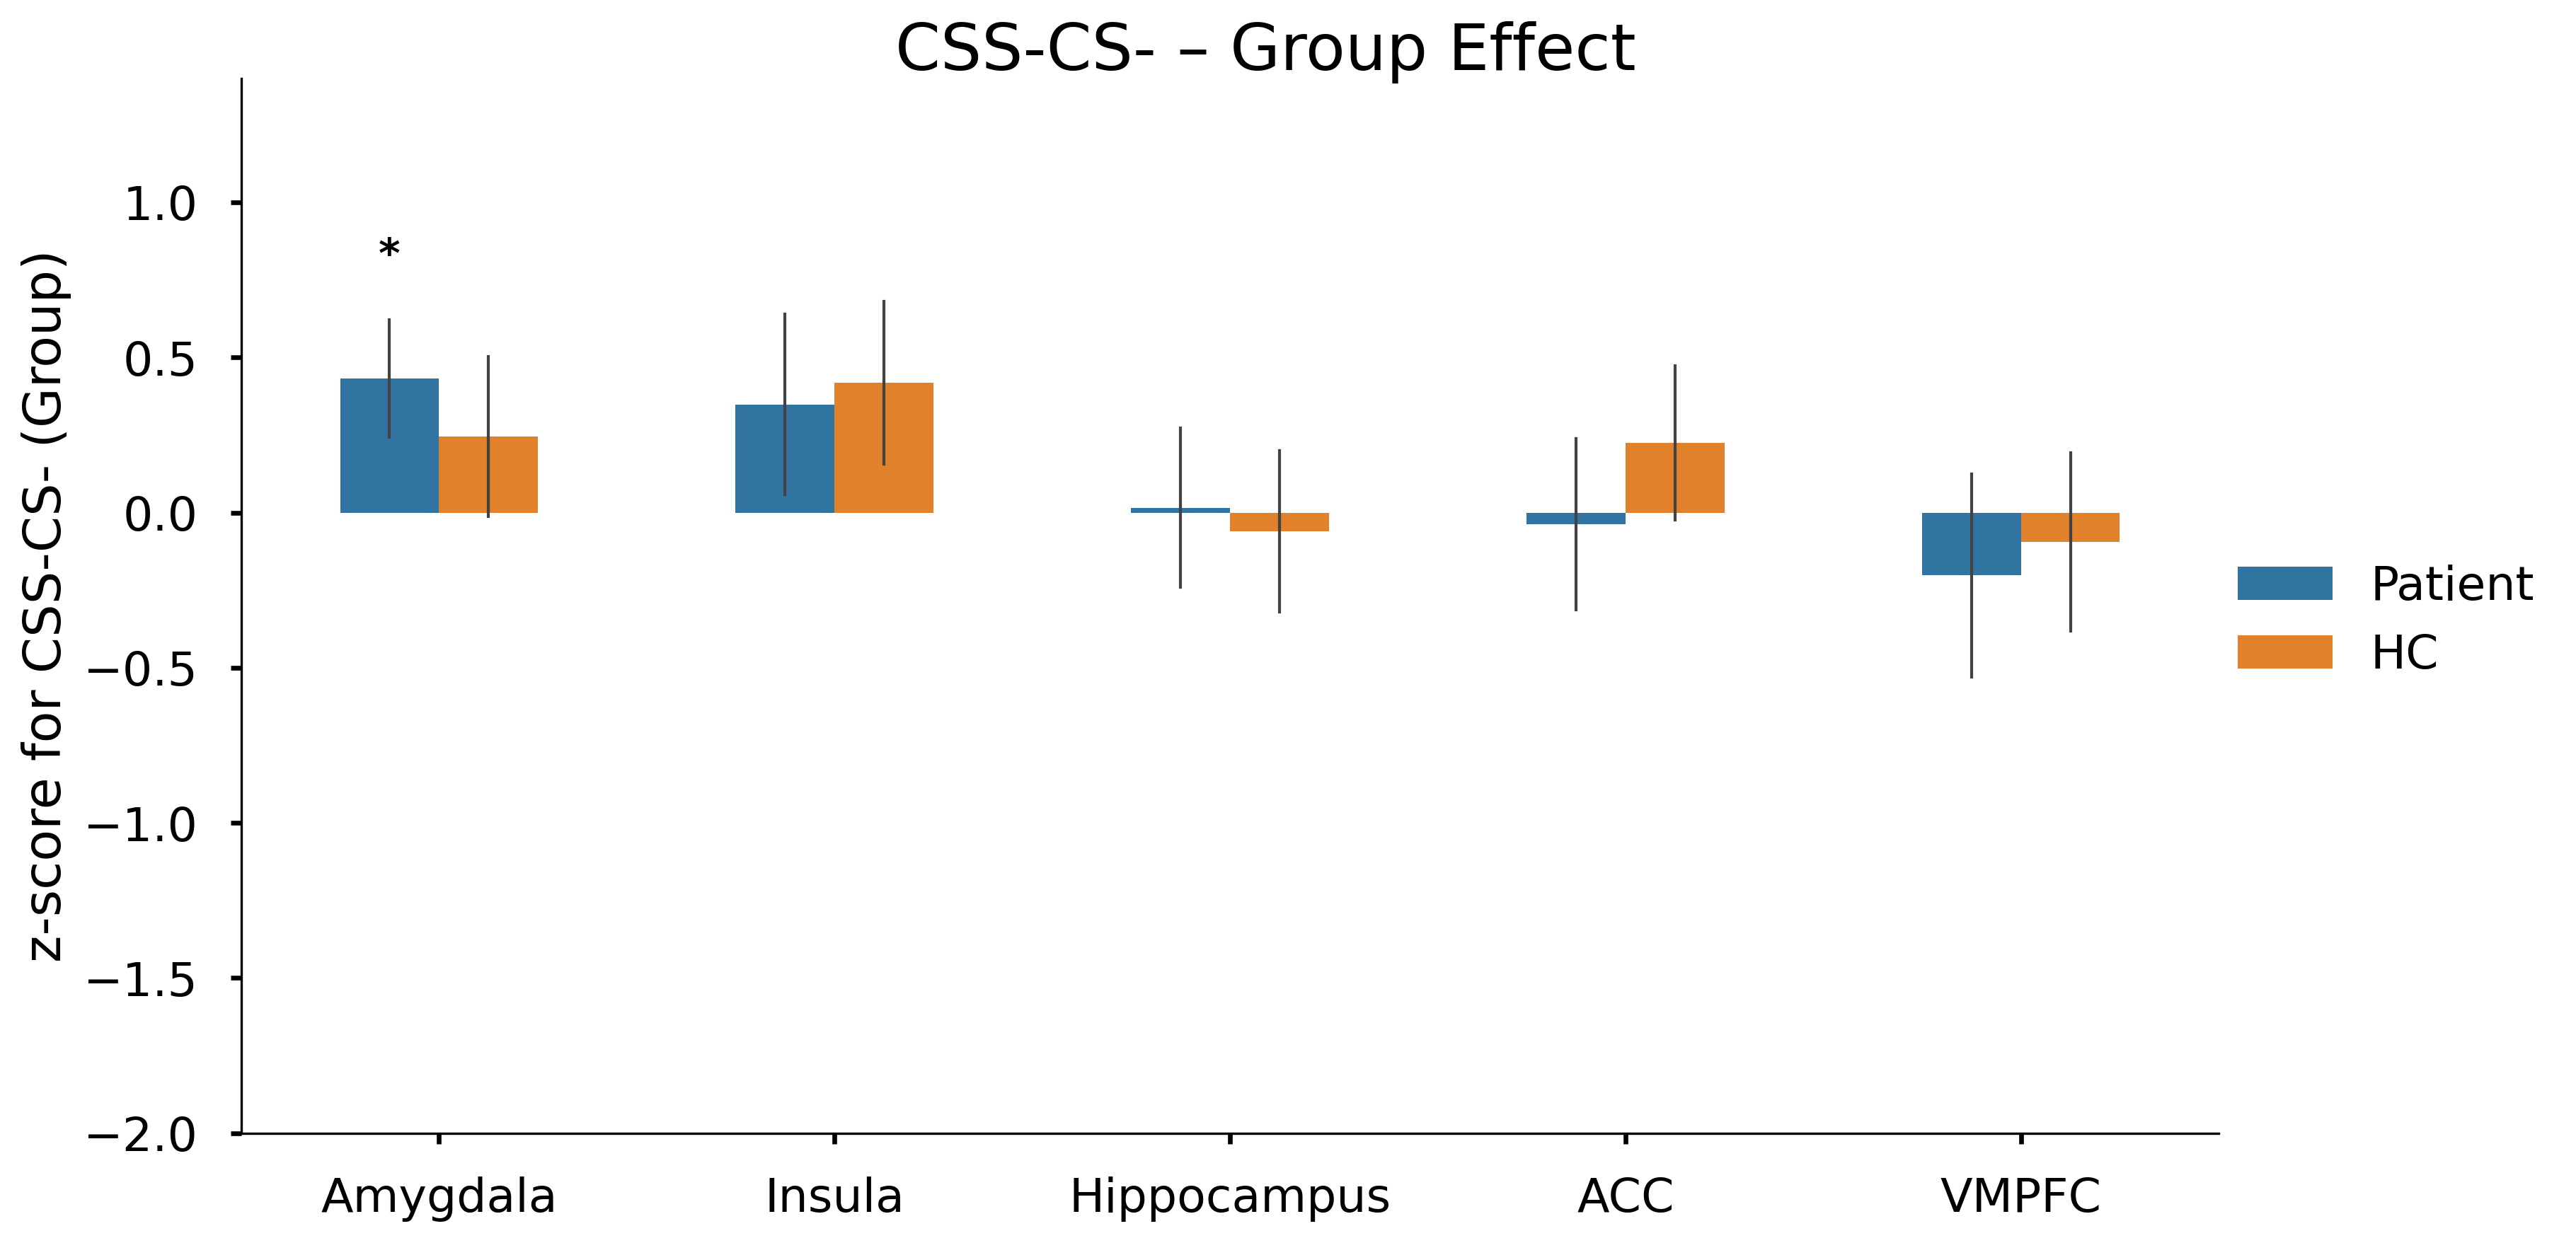


===== Group main effect: CSR-fix =====

Model results (Z_score ~ Group + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                             0.283     0.82    46    0.419      
Insula          Group[T.HC]                                             0.603     1.68    46    0.100      
Hippocampus     Group[T.HC]                                             0.124     0.28    46    0.782      
ACC             Group[T.HC]                                             0.778     1.73    46    0.090      
VMPFC           Group[T.HC]                                             0.417     1.00    46    0.324      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GROUP LEVEL
ROI             Level              

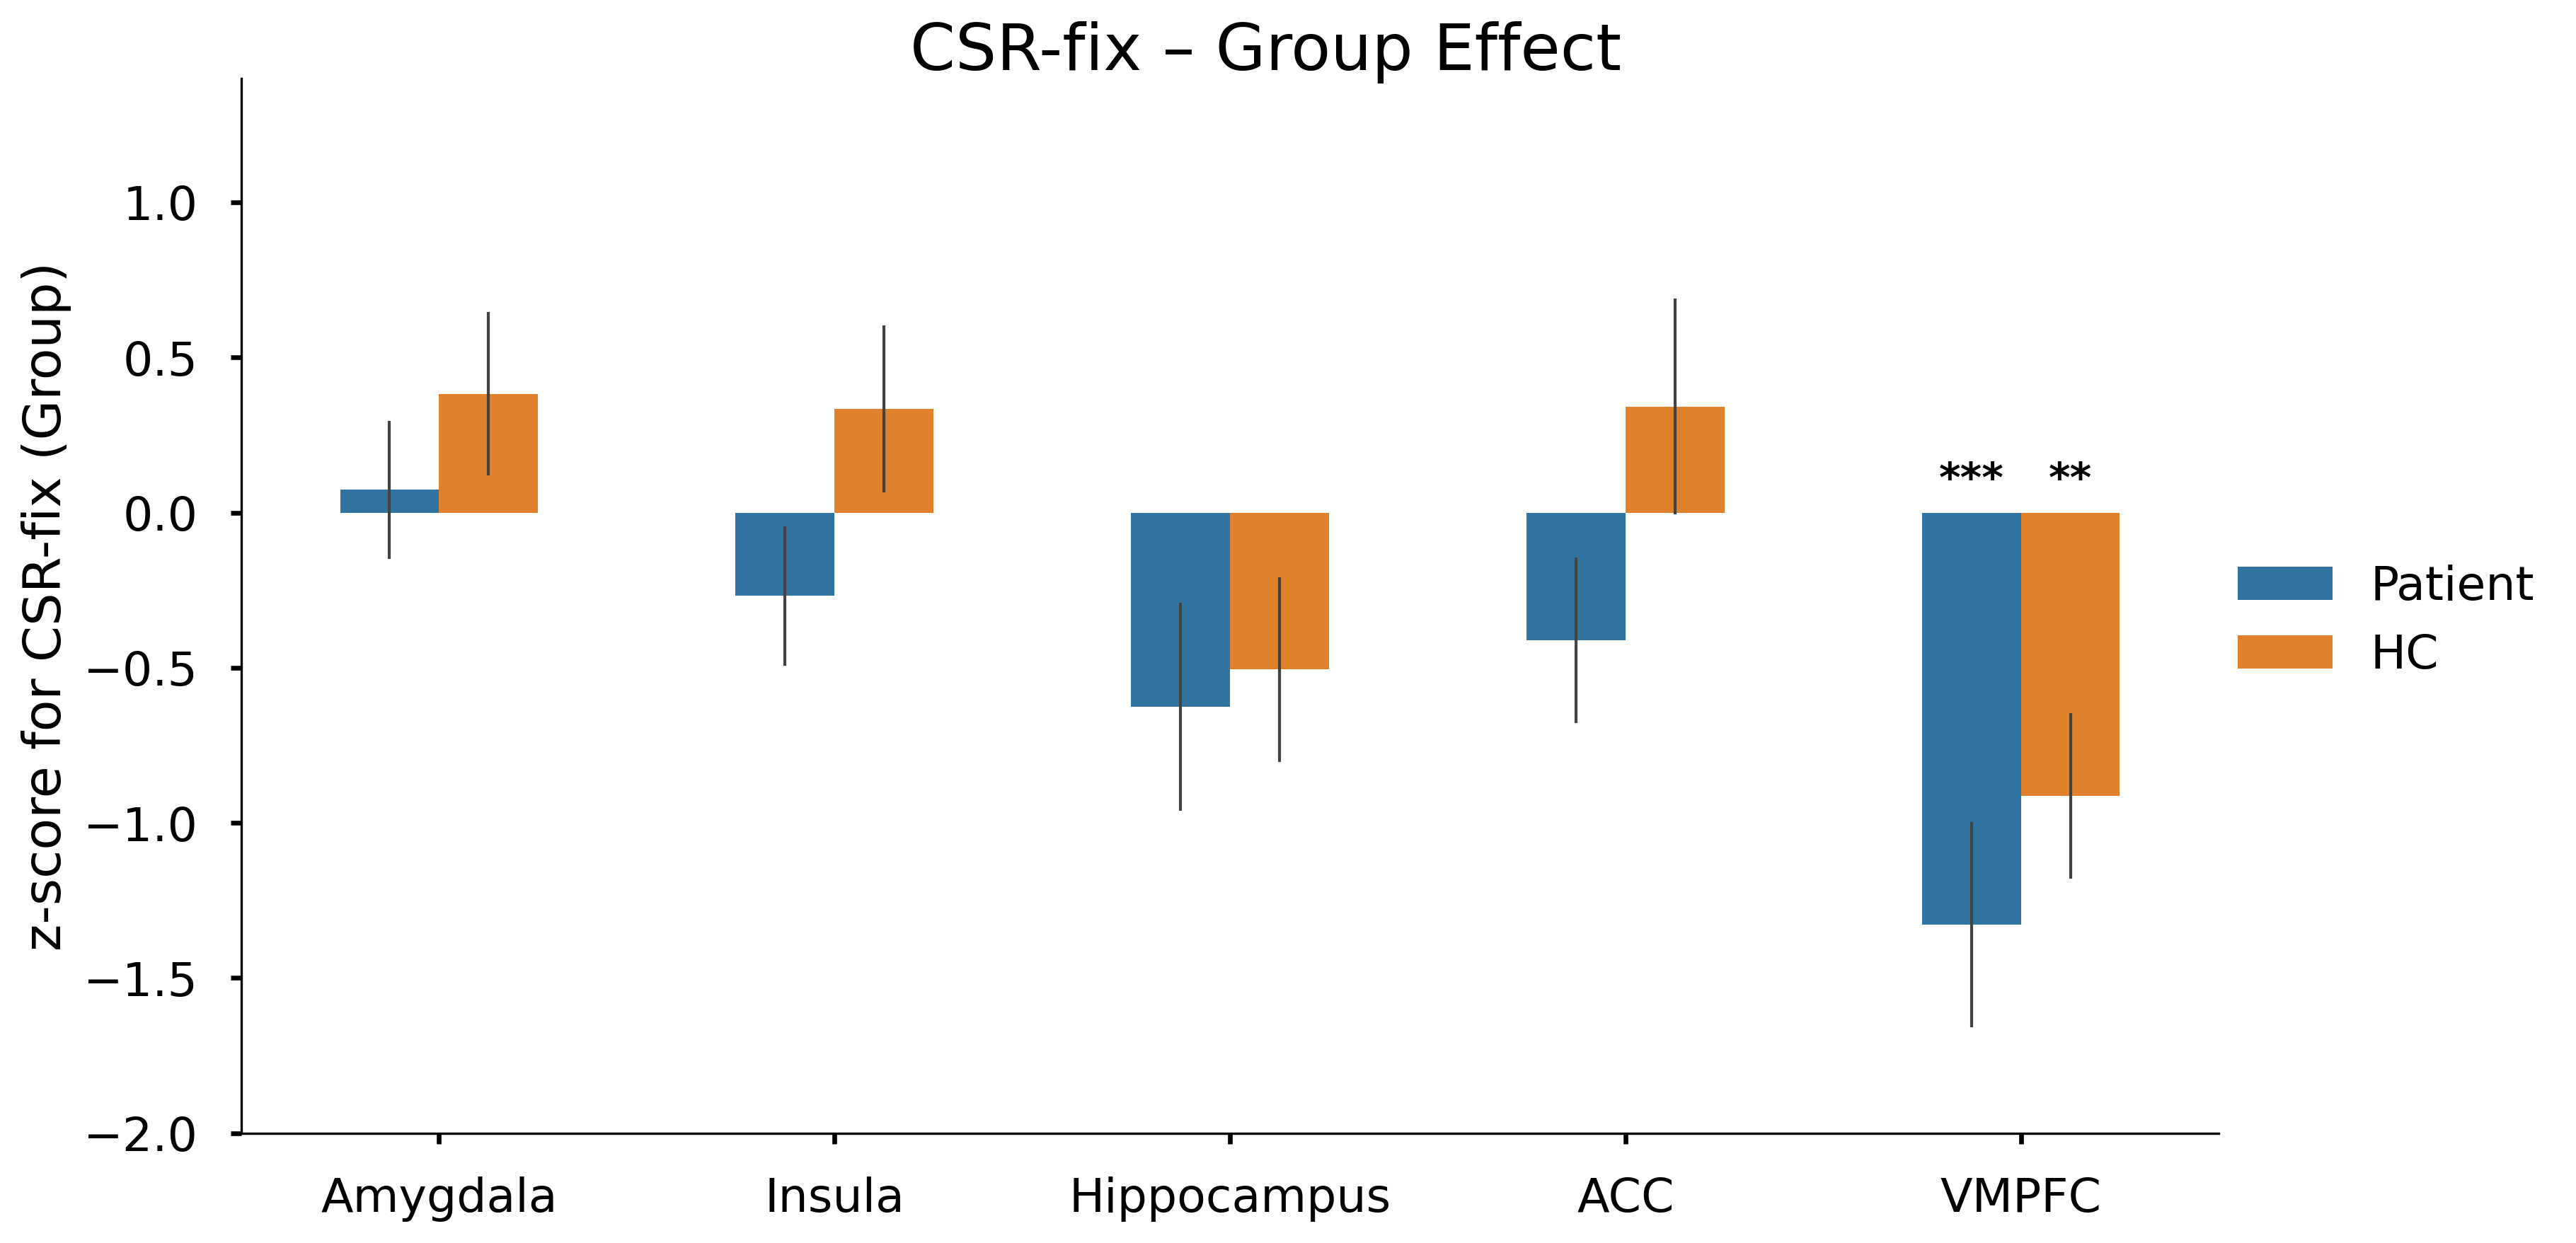


===== Group main effect: CSS-fix =====

Model results (Z_score ~ Group + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                            -0.379    -1.36    46    0.179      
Insula          Group[T.HC]                                            -0.042    -0.12    46    0.905      
Hippocampus     Group[T.HC]                                            -0.327    -1.08    46    0.286      
ACC             Group[T.HC]                                             0.357     0.95    46    0.345      
VMPFC           Group[T.HC]                                             0.466     1.15    46    0.257      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GROUP LEVEL
ROI             Level              

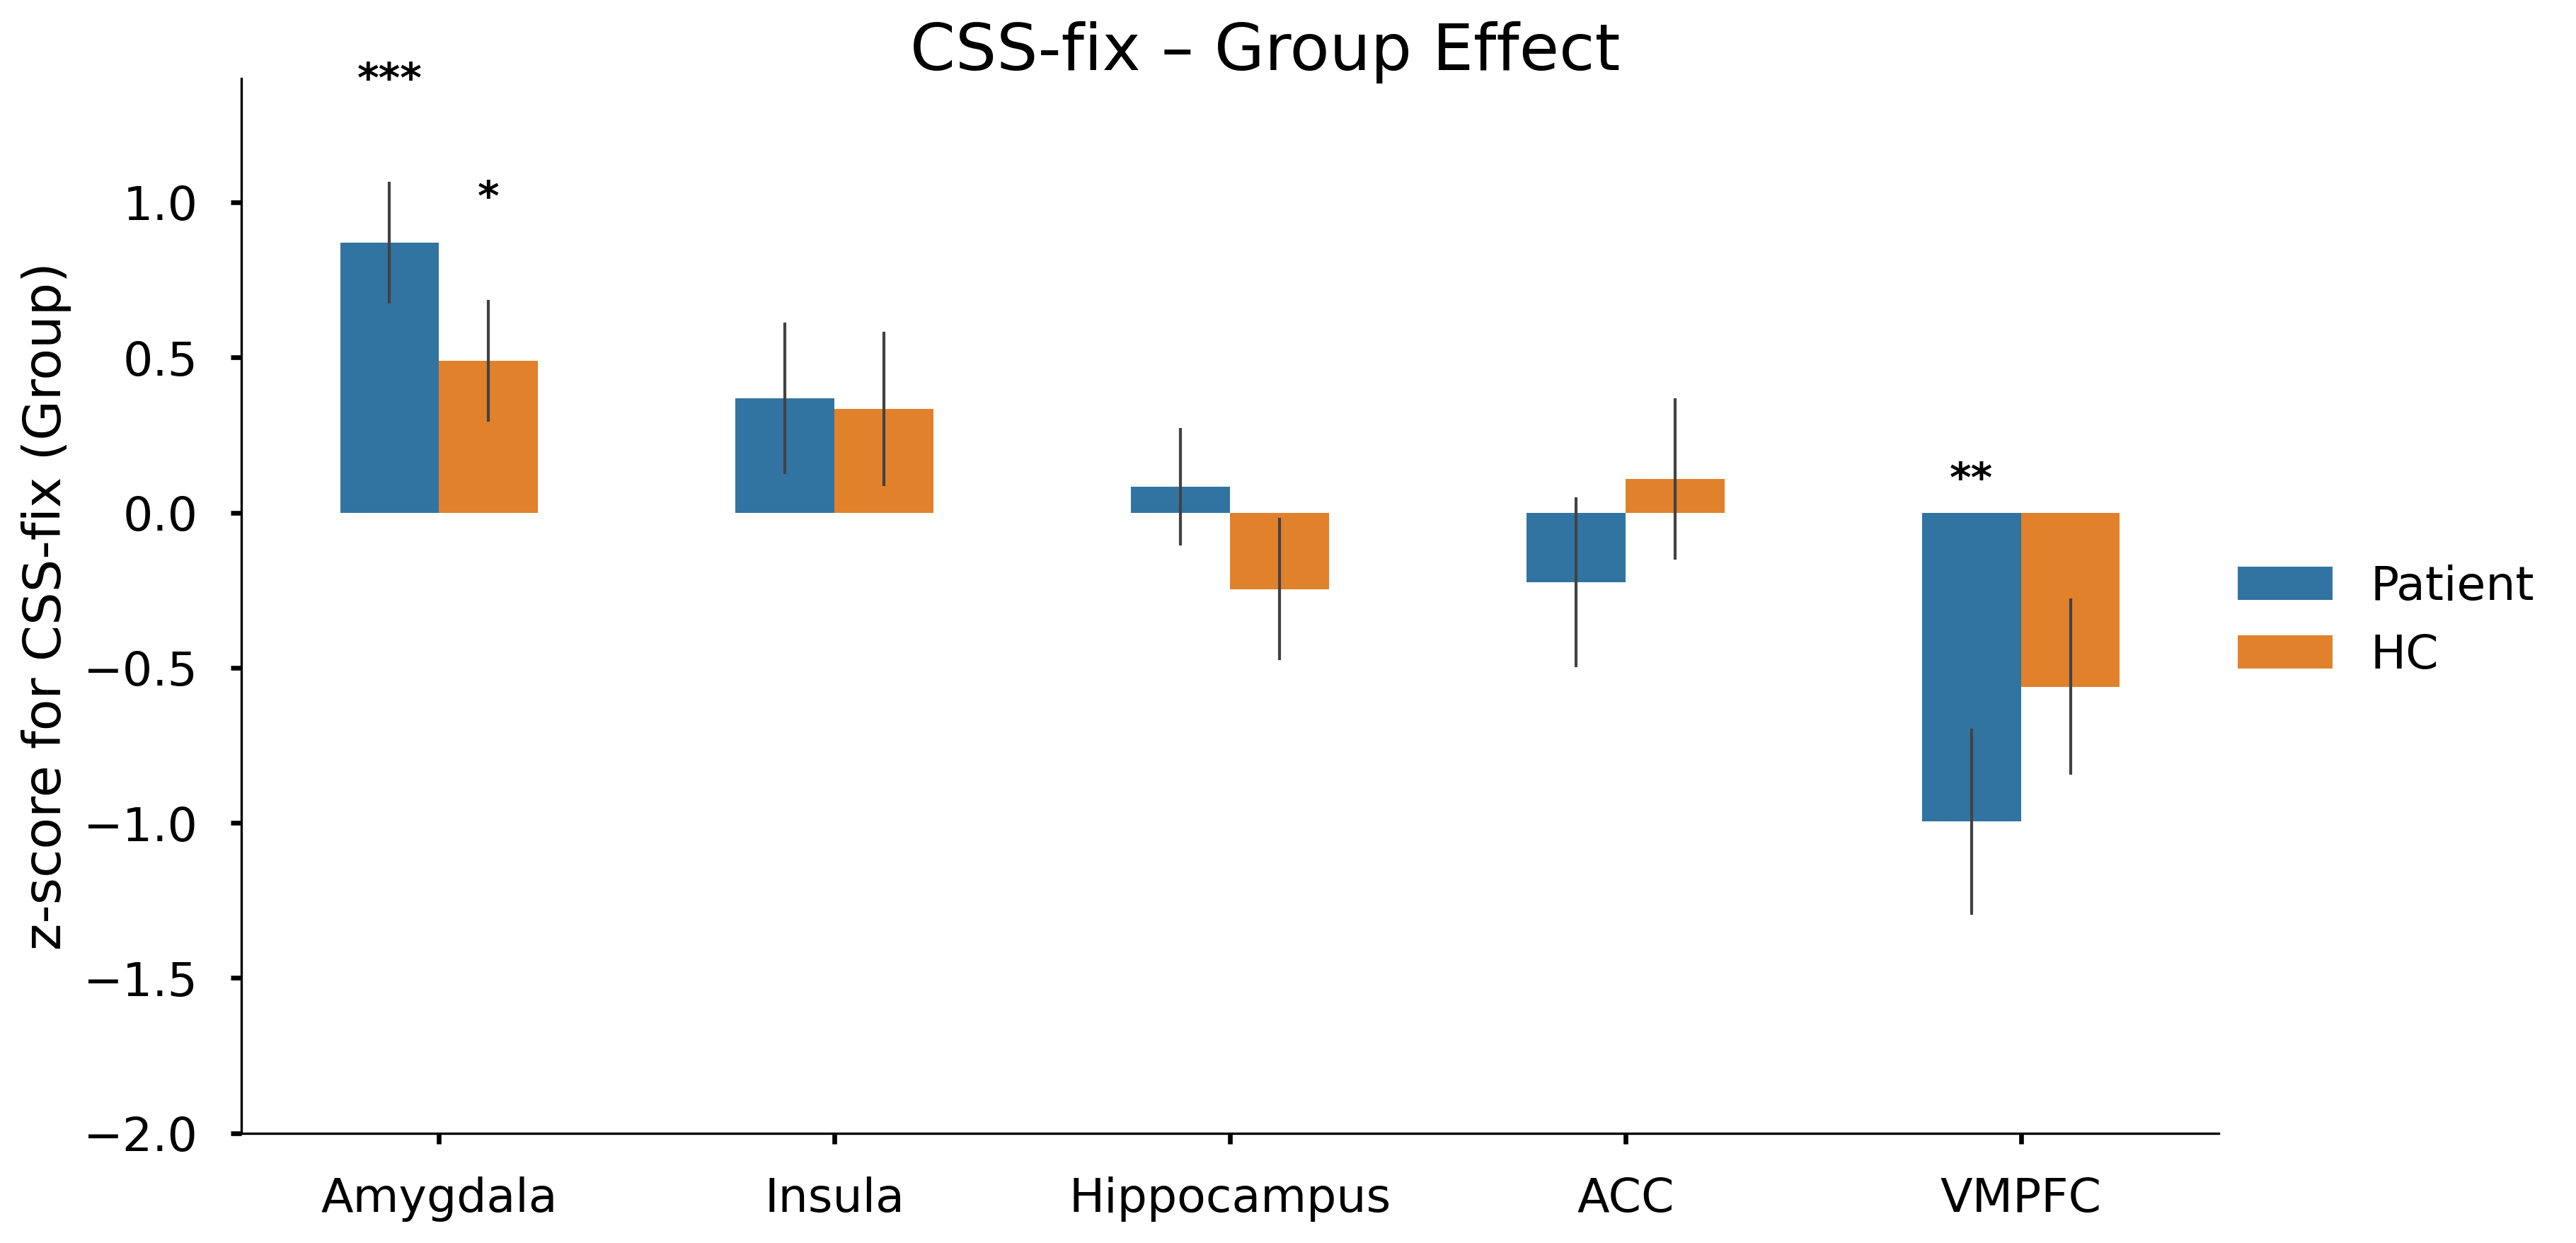


===== Group main effect: CSminus-fix =====

Model results (Z_score ~ Group + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                            -0.164    -0.50    46    0.616      
Insula          Group[T.HC]                                            -0.126    -0.31    46    0.760      
Hippocampus     Group[T.HC]                                            -0.275    -0.74    46    0.464      
ACC             Group[T.HC]                                             0.036     0.10    46    0.924      
VMPFC           Group[T.HC]                                             0.339     0.86    46    0.394      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GROUP LEVEL
ROI             Level          

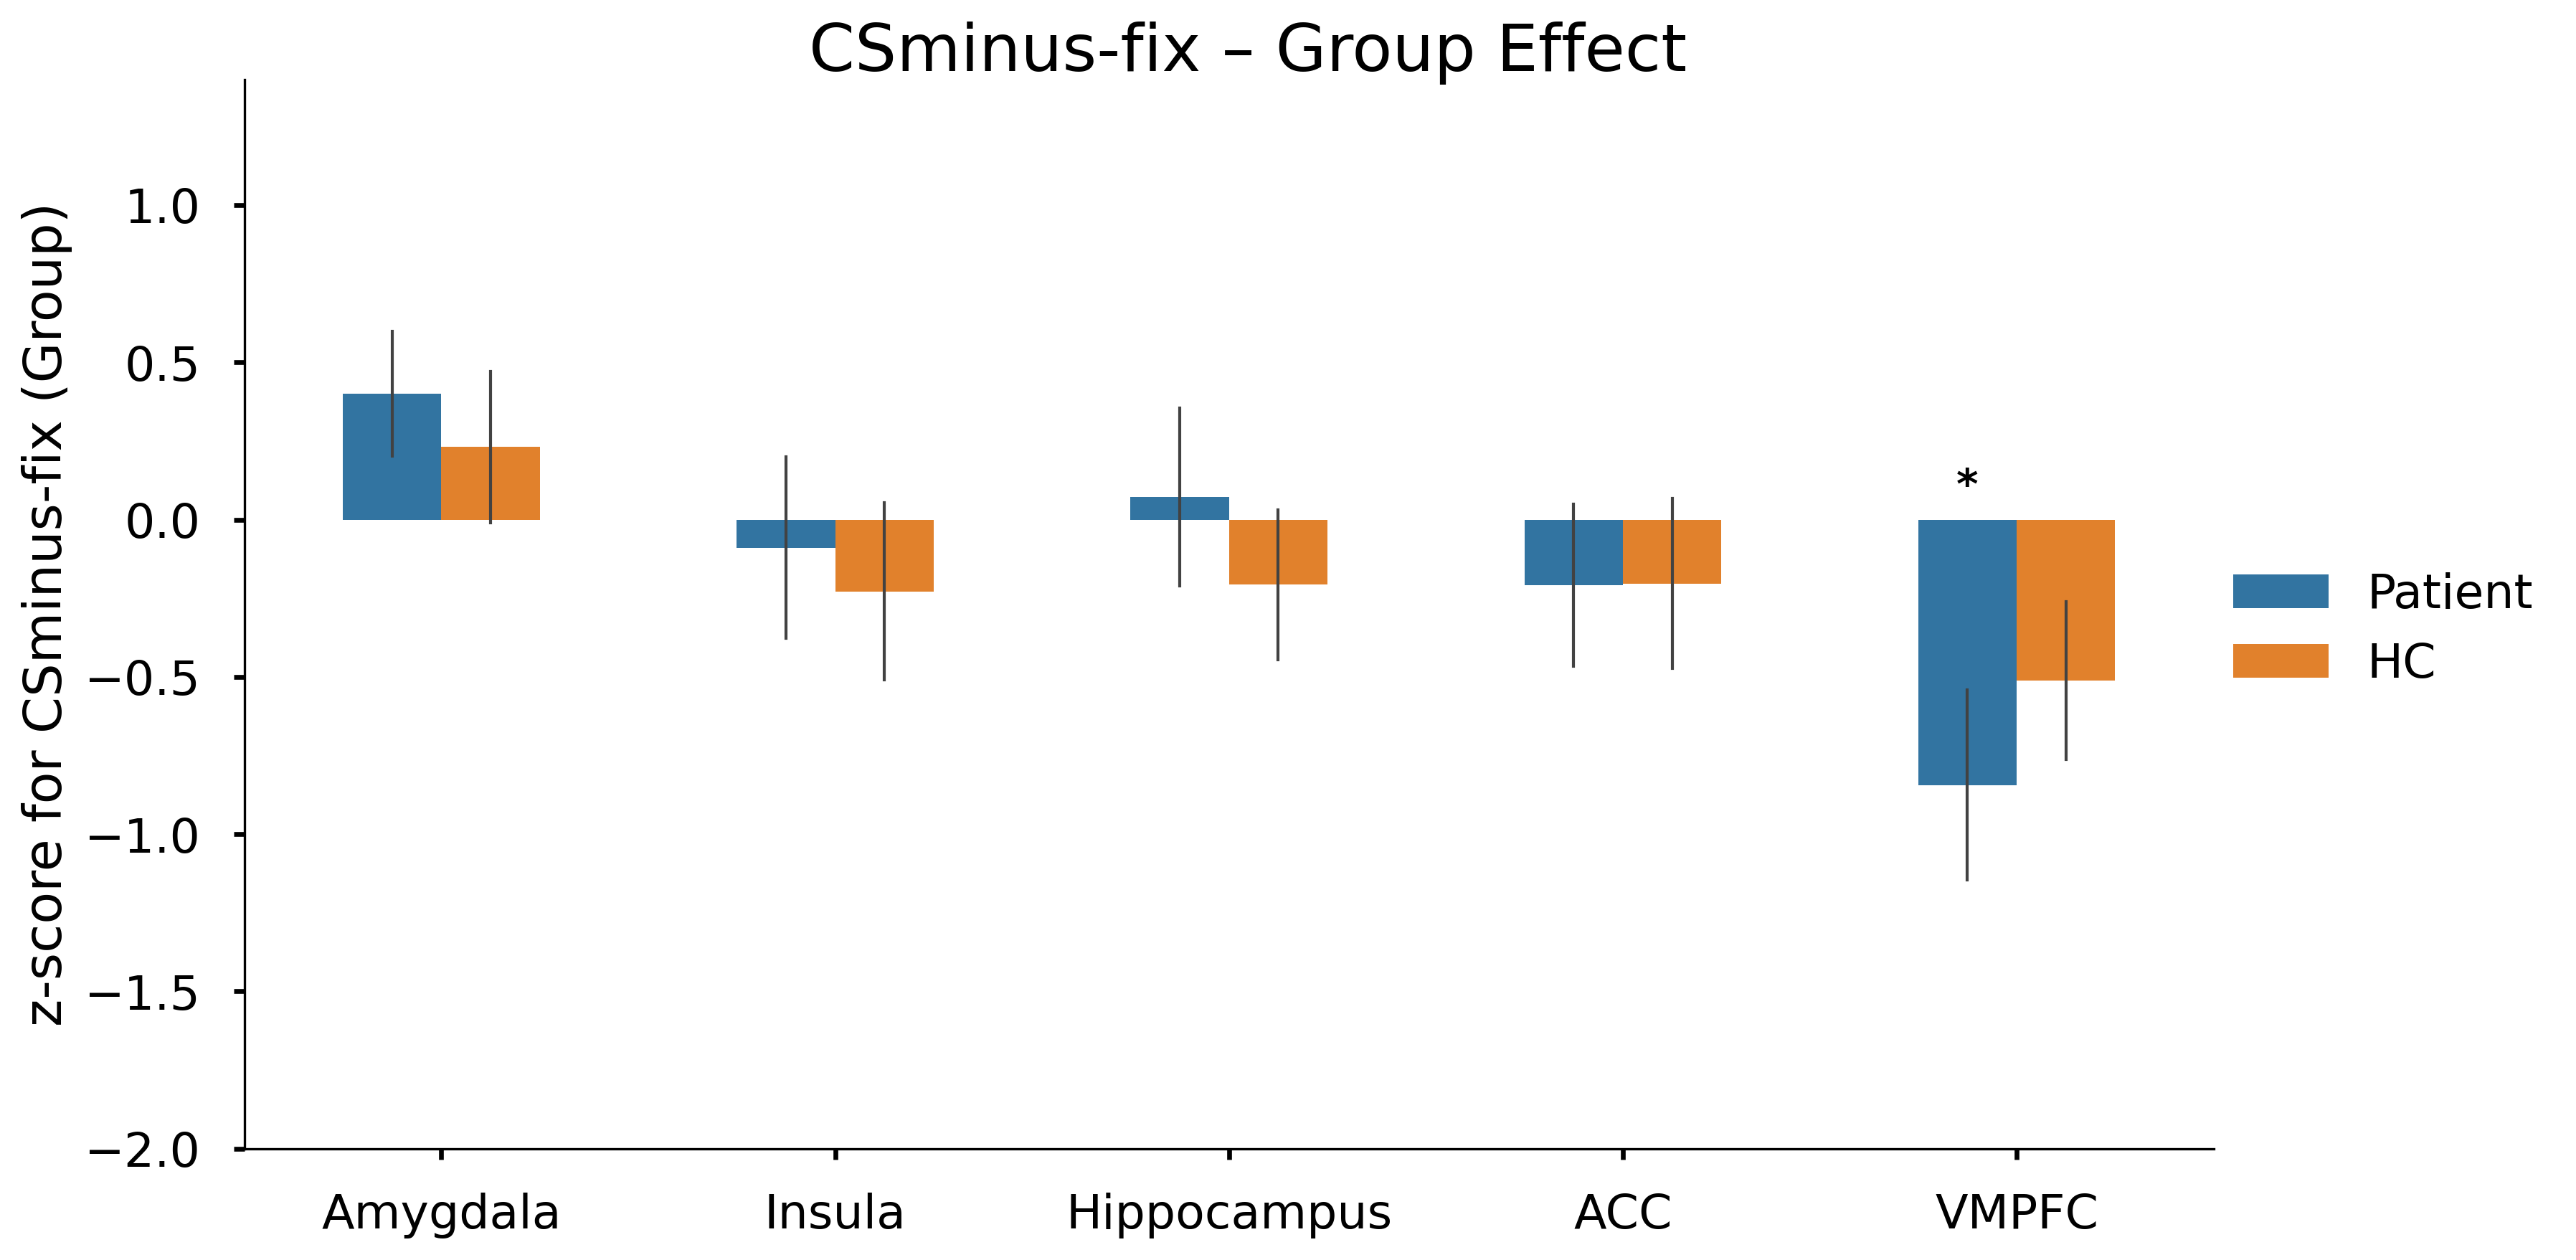

In [ ]:
# 1️⃣ Group main effect
# ---------------------------------------------------------
for contrast in contrast_list:
    print(f"\n===== Group main effect: {contrast} =====")
    df = df_all.loc[(df_all['Contrast'] == contrast) & (df_all['Drug'] == 'Placebo') & (df_all['Phase'] == 'phase2')]

    g = sns.catplot(
        x='ROI', y='Z_score', hue='Group',
        order=ROI_list, hue_order=group_list,
        kind='bar', errorbar='se', 
        height=6, aspect=1.8, width=0.5, 
        err_kws={'linewidth': 1},
        data=df
    )

    ax = g.ax
    add_sig_stars(ax, df, ROI_list, get_matching_model_terms(model, "Group")[0], hue_order=group_list)


    g.set_axis_labels('', f'z-score for {contrast} (Group)')
    g.set(ylim=(-2, 1.4))
    g.legend.set_title('')
    g.figure.suptitle(f'{contrast} – Group Effect', fontsize=22, y=1.02)
    g.figure.set_dpi(300)
    plt.savefig(f'{plot_dir}/{contrast}_Group_sig.png', bbox_inches='tight')
    plt.show()


===== Gender main effect: CSR-CSS =====

Model results (Z_score ~ Gender + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Gender[T.Female]                                        0.317     1.40    97    0.166      
Insula          Gender[T.Female]                                       -0.348    -1.42    97    0.157      
Hippocampus     Gender[T.Female]                                        0.194     0.77    97    0.443      
ACC             Gender[T.Female]                                       -0.094    -0.38    97    0.702      
VMPFC           Gender[T.Female]                                        0.198     0.74    97    0.464      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GENDER LEVEL
ROI             Level           

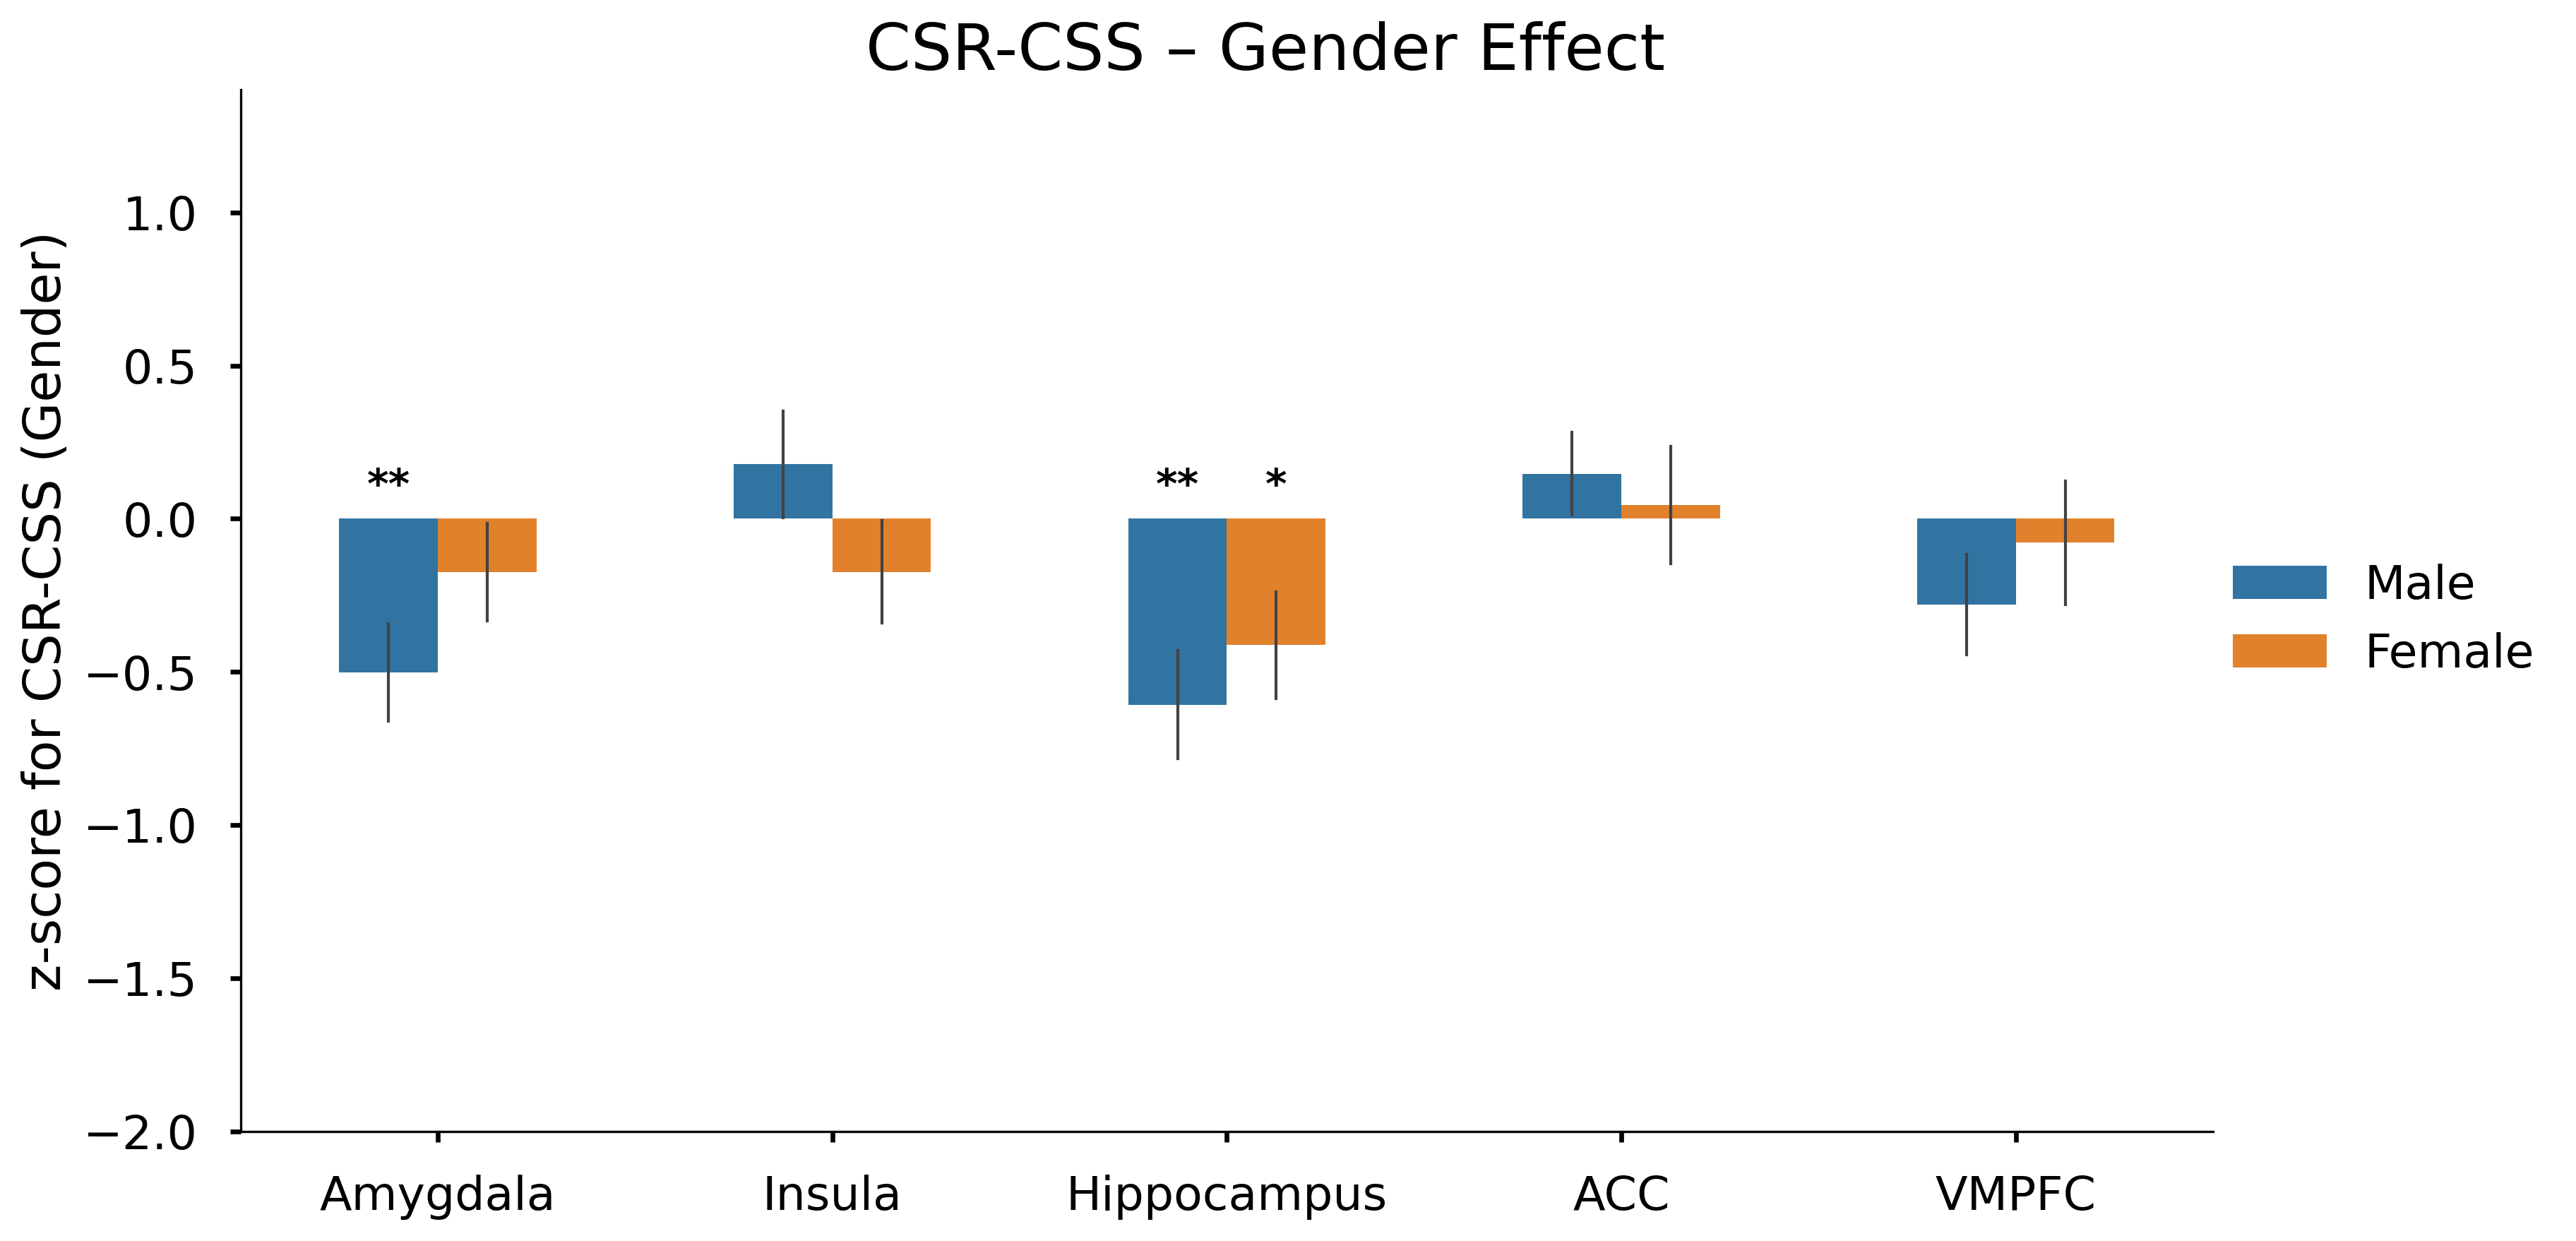


===== Gender main effect: CSR-CS- =====

Model results (Z_score ~ Gender + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Gender[T.Female]                                        0.328     1.44    97    0.154      
Insula          Gender[T.Female]                                       -0.043    -0.15    97    0.882      
Hippocampus     Gender[T.Female]                                        0.011     0.04    97    0.970      
ACC             Gender[T.Female]                                       -0.260    -0.88    97    0.382      
VMPFC           Gender[T.Female]                                       -0.040    -0.13    97    0.897      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GENDER LEVEL
ROI             Level           

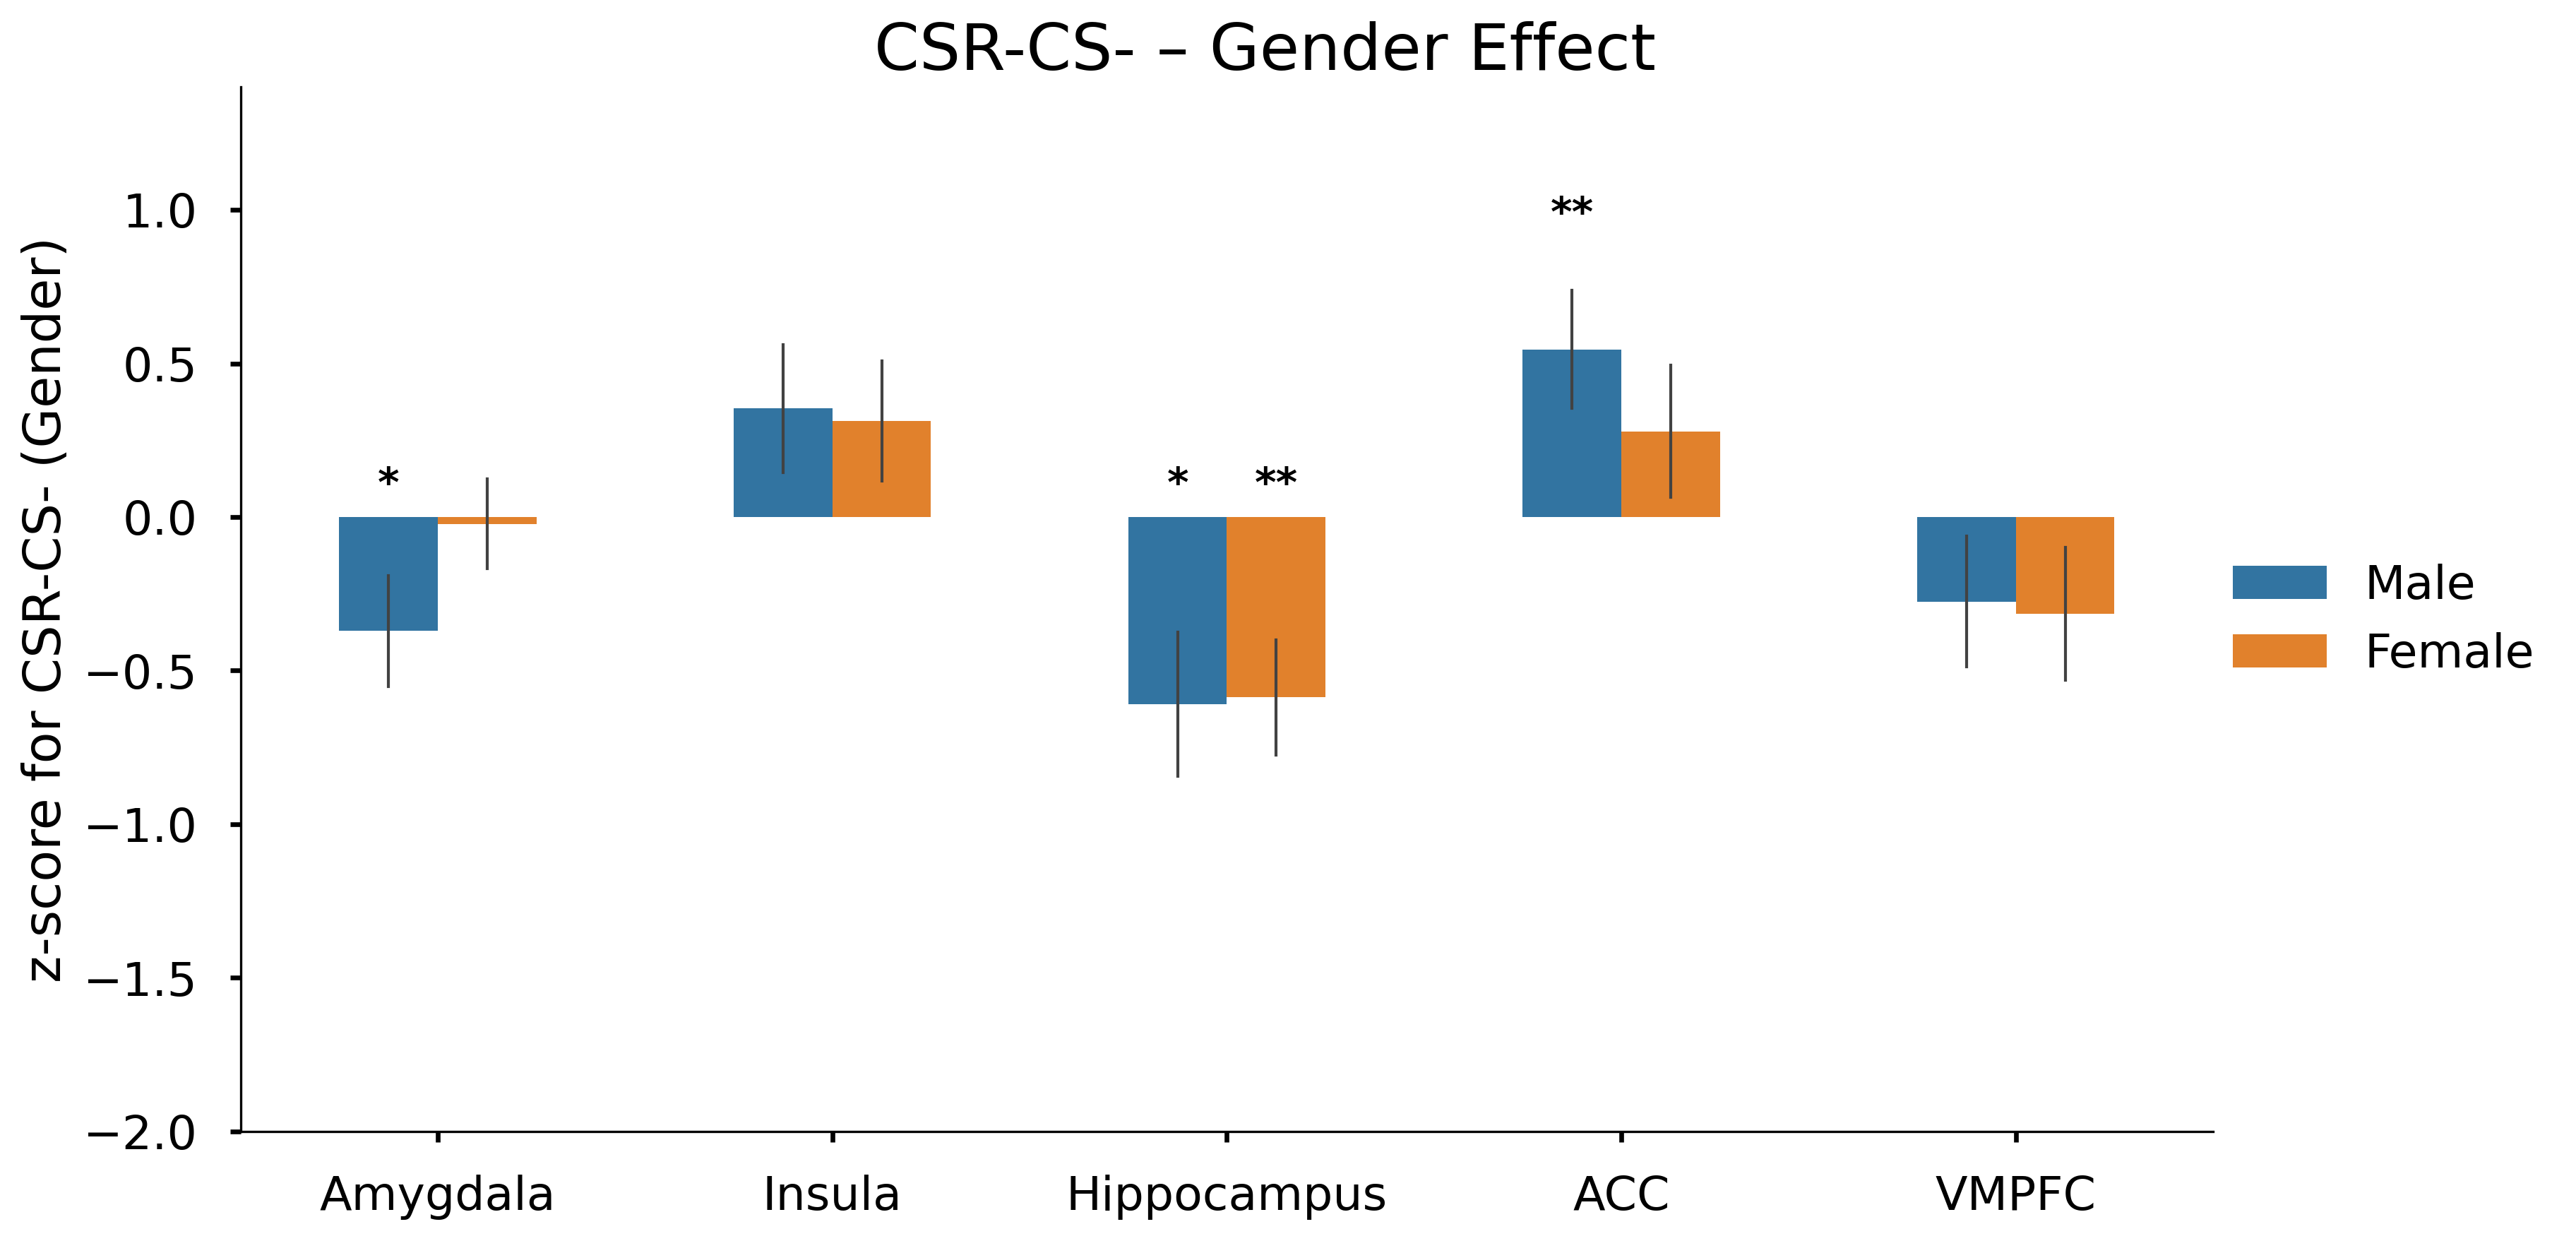


===== Gender main effect: CSS-CS- =====

Model results (Z_score ~ Gender + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Gender[T.Female]                                       -0.031    -0.14    97    0.887      
Insula          Gender[T.Female]                                        0.323     1.17    97    0.245      
Hippocampus     Gender[T.Female]                                       -0.214    -0.91    97    0.366      
ACC             Gender[T.Female]                                       -0.163    -0.59    97    0.555      
VMPFC           Gender[T.Female]                                       -0.258    -0.95    97    0.346      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GENDER LEVEL
ROI             Level           

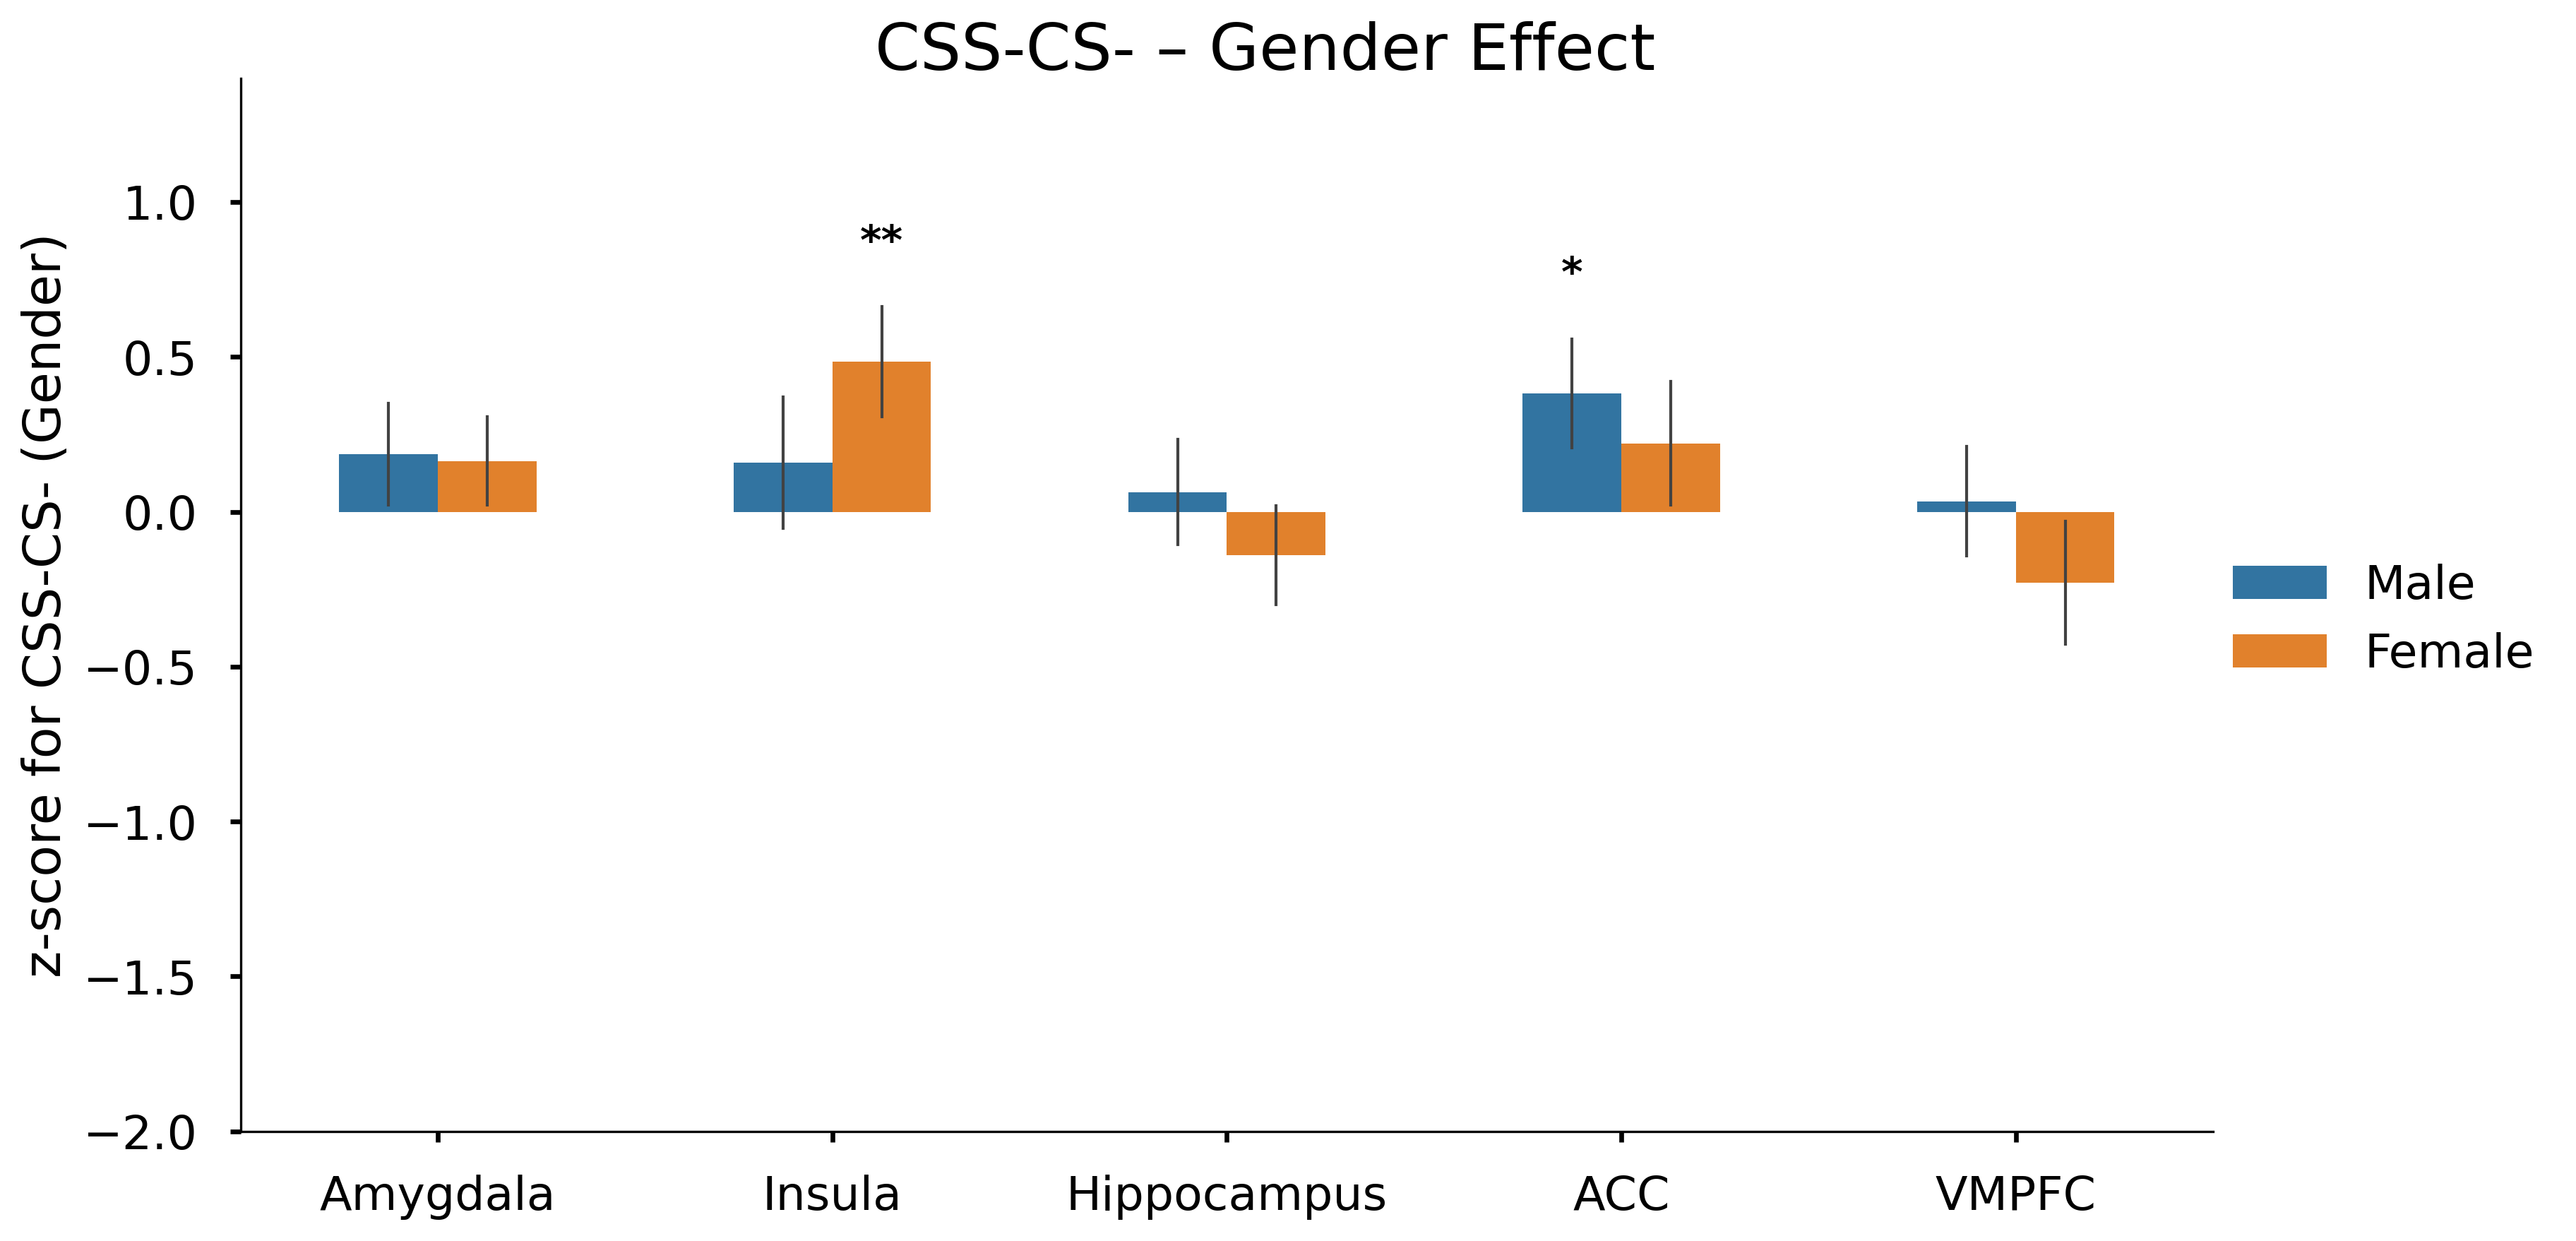


===== Gender main effect: CSR-fix =====

Model results (Z_score ~ Gender + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Gender[T.Female]                                        0.512     2.09    97    0.039     *
Insula          Gender[T.Female]                                       -0.276    -1.14    97    0.257      
Hippocampus     Gender[T.Female]                                        0.318     1.13    97    0.263      
ACC             Gender[T.Female]                                       -0.607    -2.08    97    0.040     *
VMPFC           Gender[T.Female]                                        0.060     0.20    97    0.846      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GENDER LEVEL
ROI             Level           

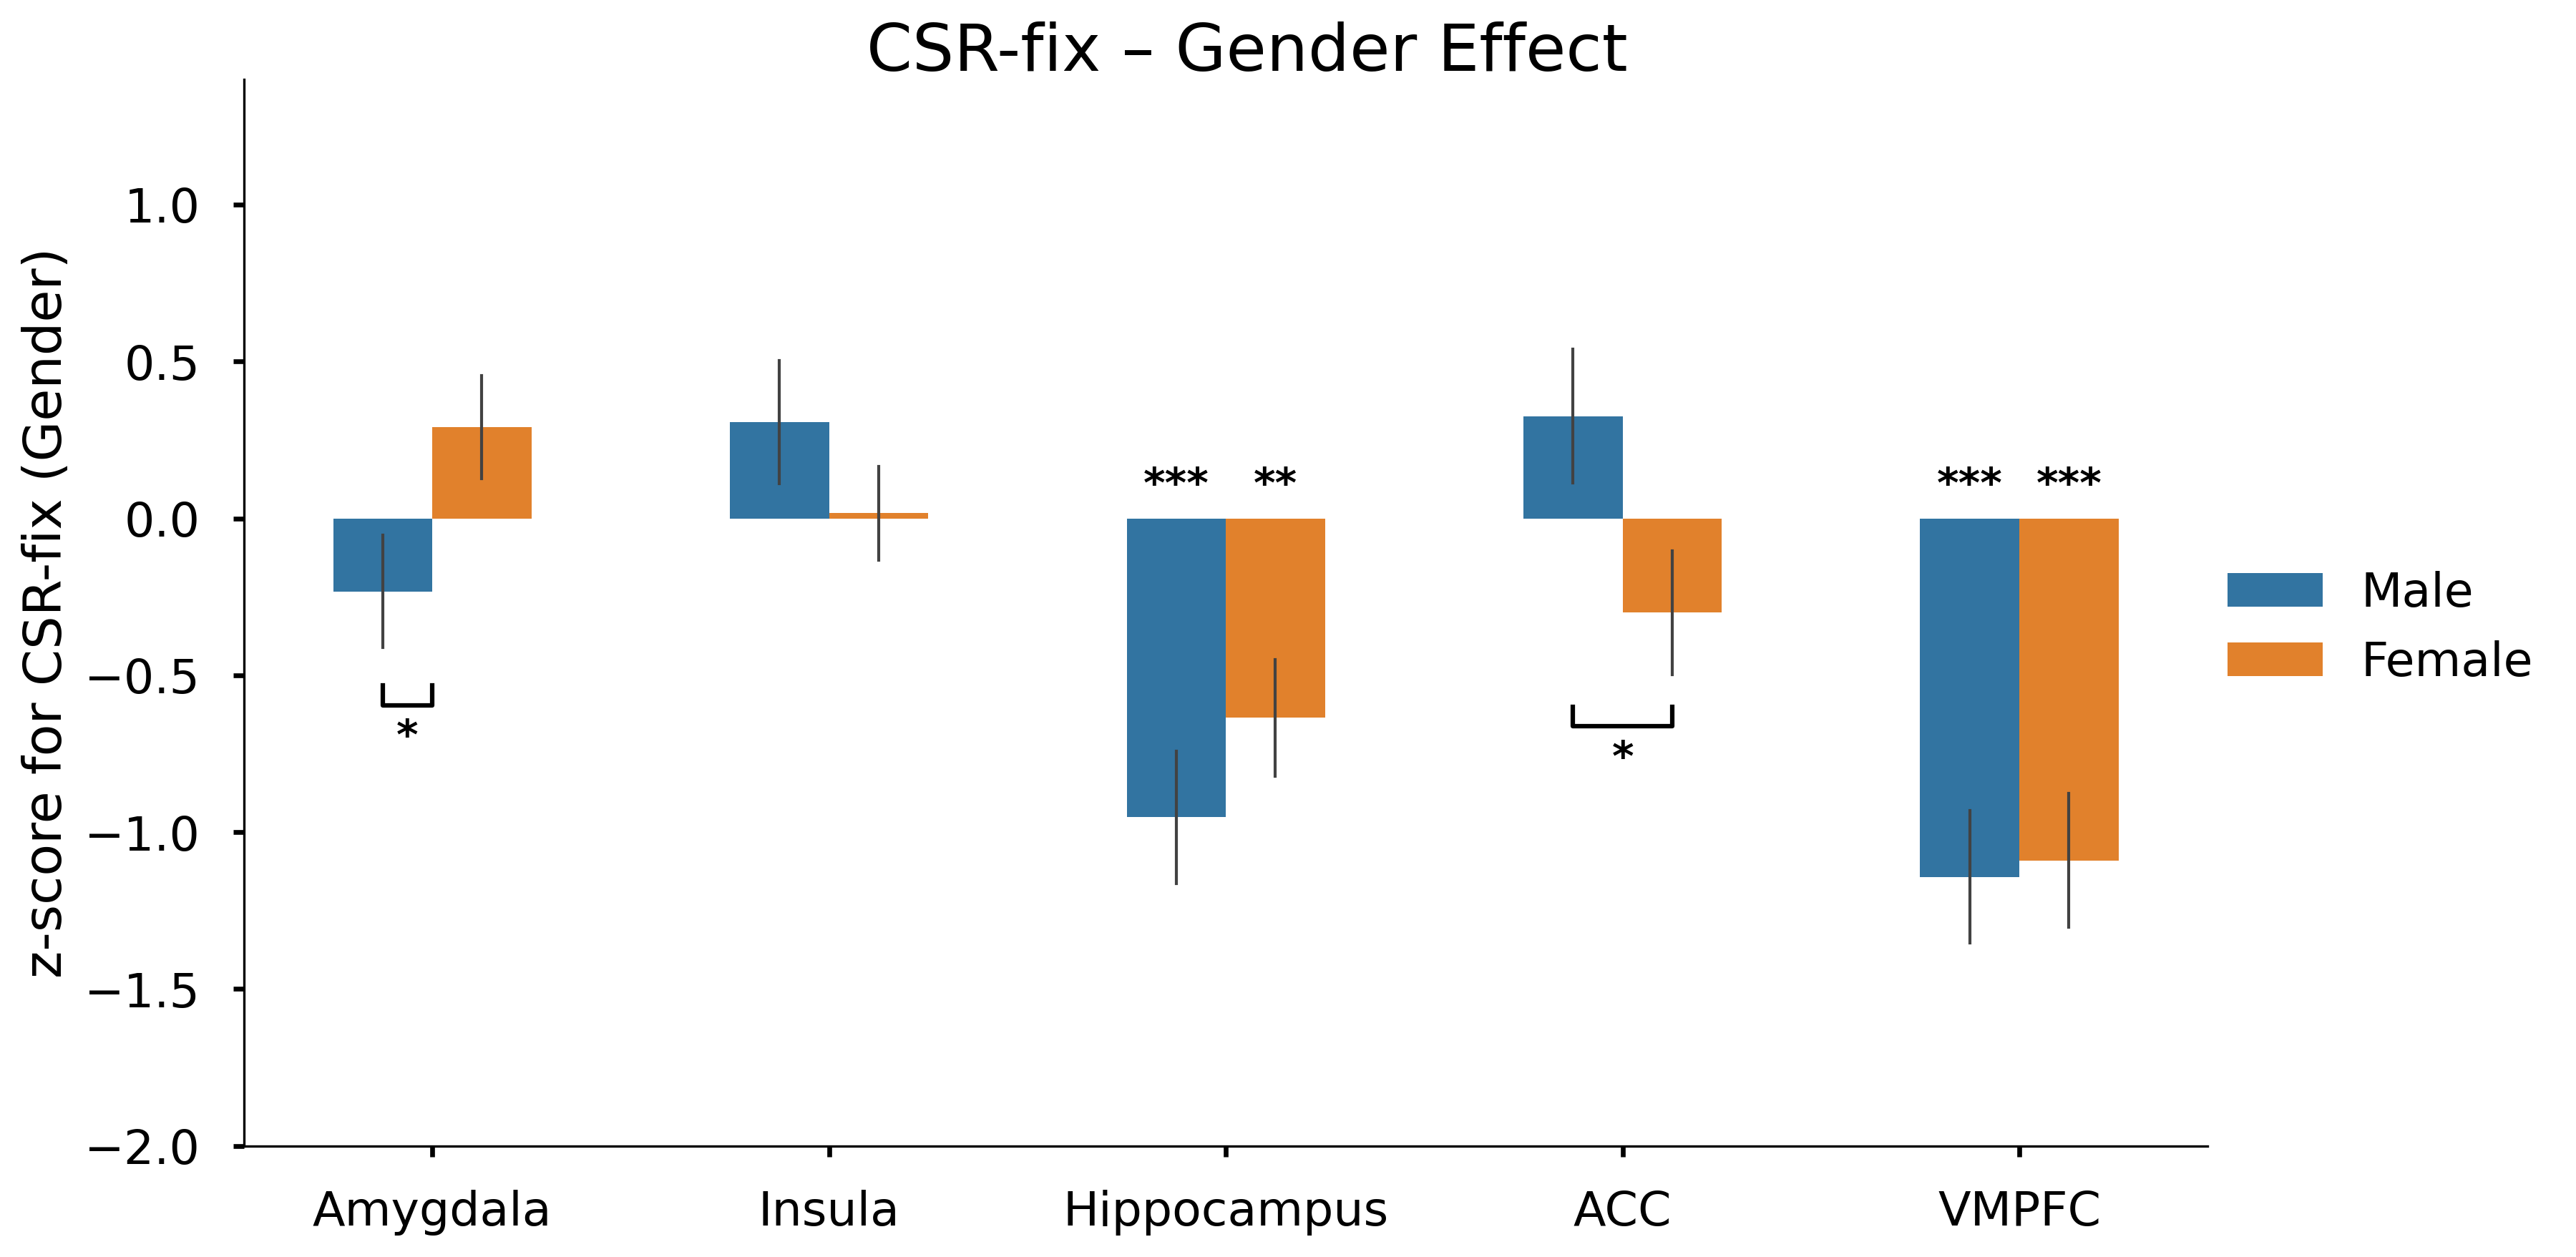


===== Gender main effect: CSS-fix =====

Model results (Z_score ~ Gender + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Gender[T.Female]                                        0.067     0.29    97    0.771      
Insula          Gender[T.Female]                                        0.198     0.78    97    0.436      
Hippocampus     Gender[T.Female]                                        0.048     0.21    97    0.836      
ACC             Gender[T.Female]                                       -0.469    -1.81    97    0.074      
VMPFC           Gender[T.Female]                                       -0.220    -0.79    97    0.431      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GENDER LEVEL
ROI             Level           

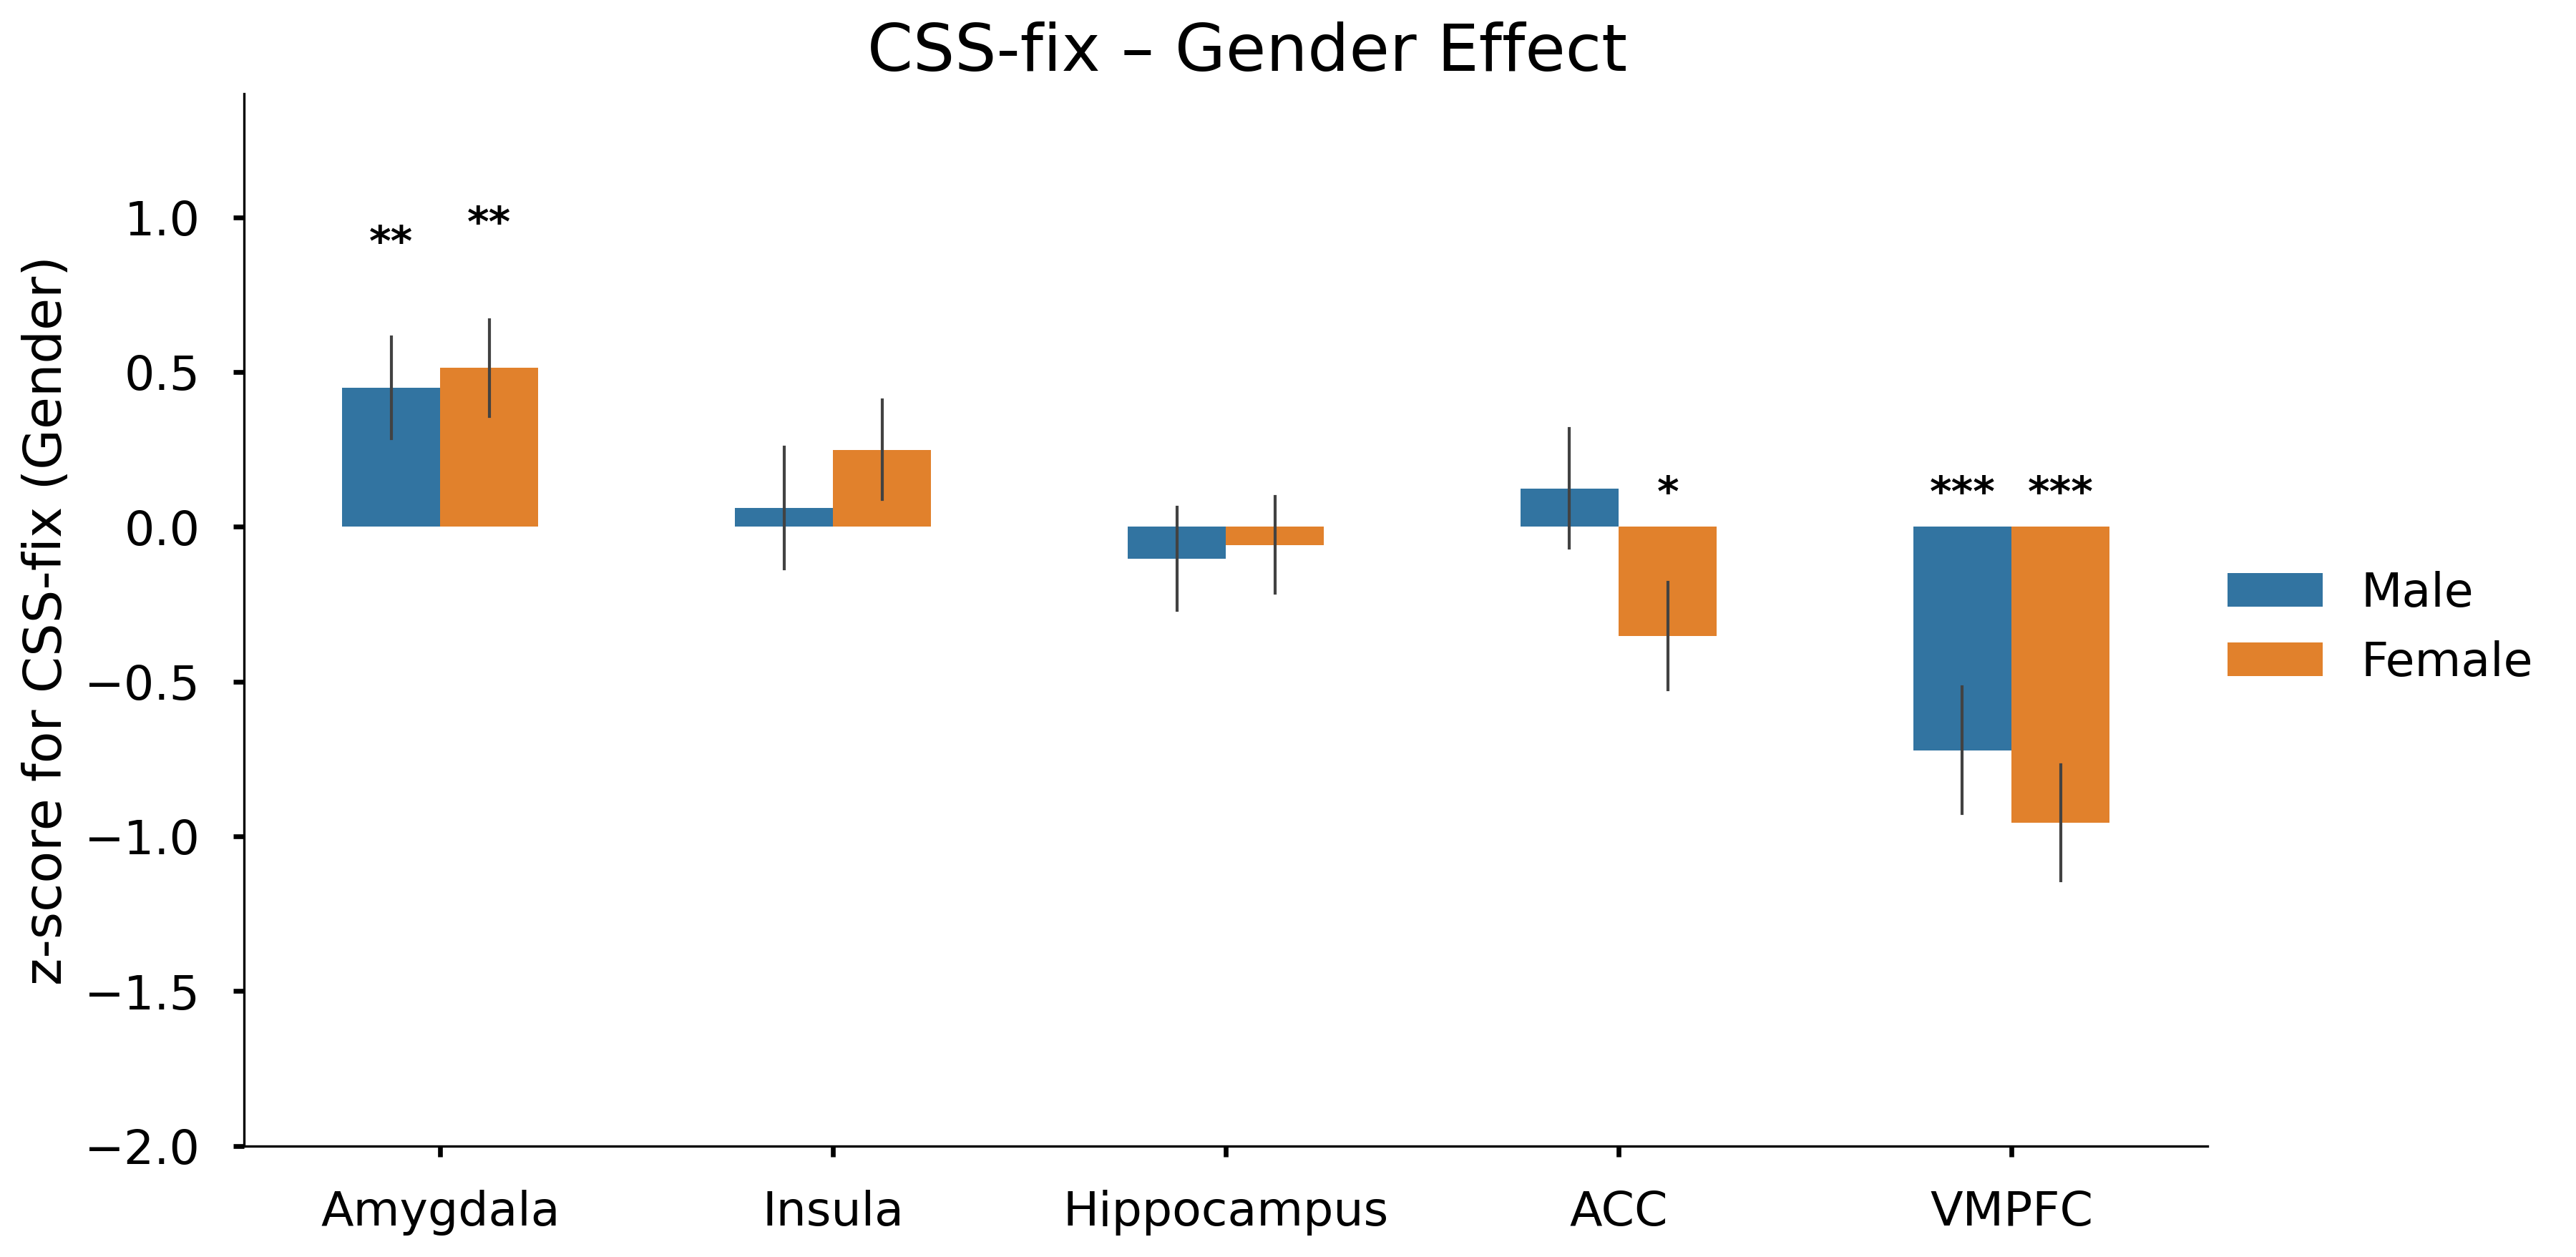


===== Gender main effect: CSminus-fix =====

Model results (Z_score ~ Gender + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Gender[T.Female]                                        0.106     0.46    97    0.650      
Insula          Gender[T.Female]                                       -0.250    -0.85    97    0.400      
Hippocampus     Gender[T.Female]                                        0.340     1.25    97    0.214      
ACC             Gender[T.Female]                                       -0.304    -1.04    97    0.303      
VMPFC           Gender[T.Female]                                        0.134     0.44    97    0.659      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GENDER LEVEL
ROI             Level       

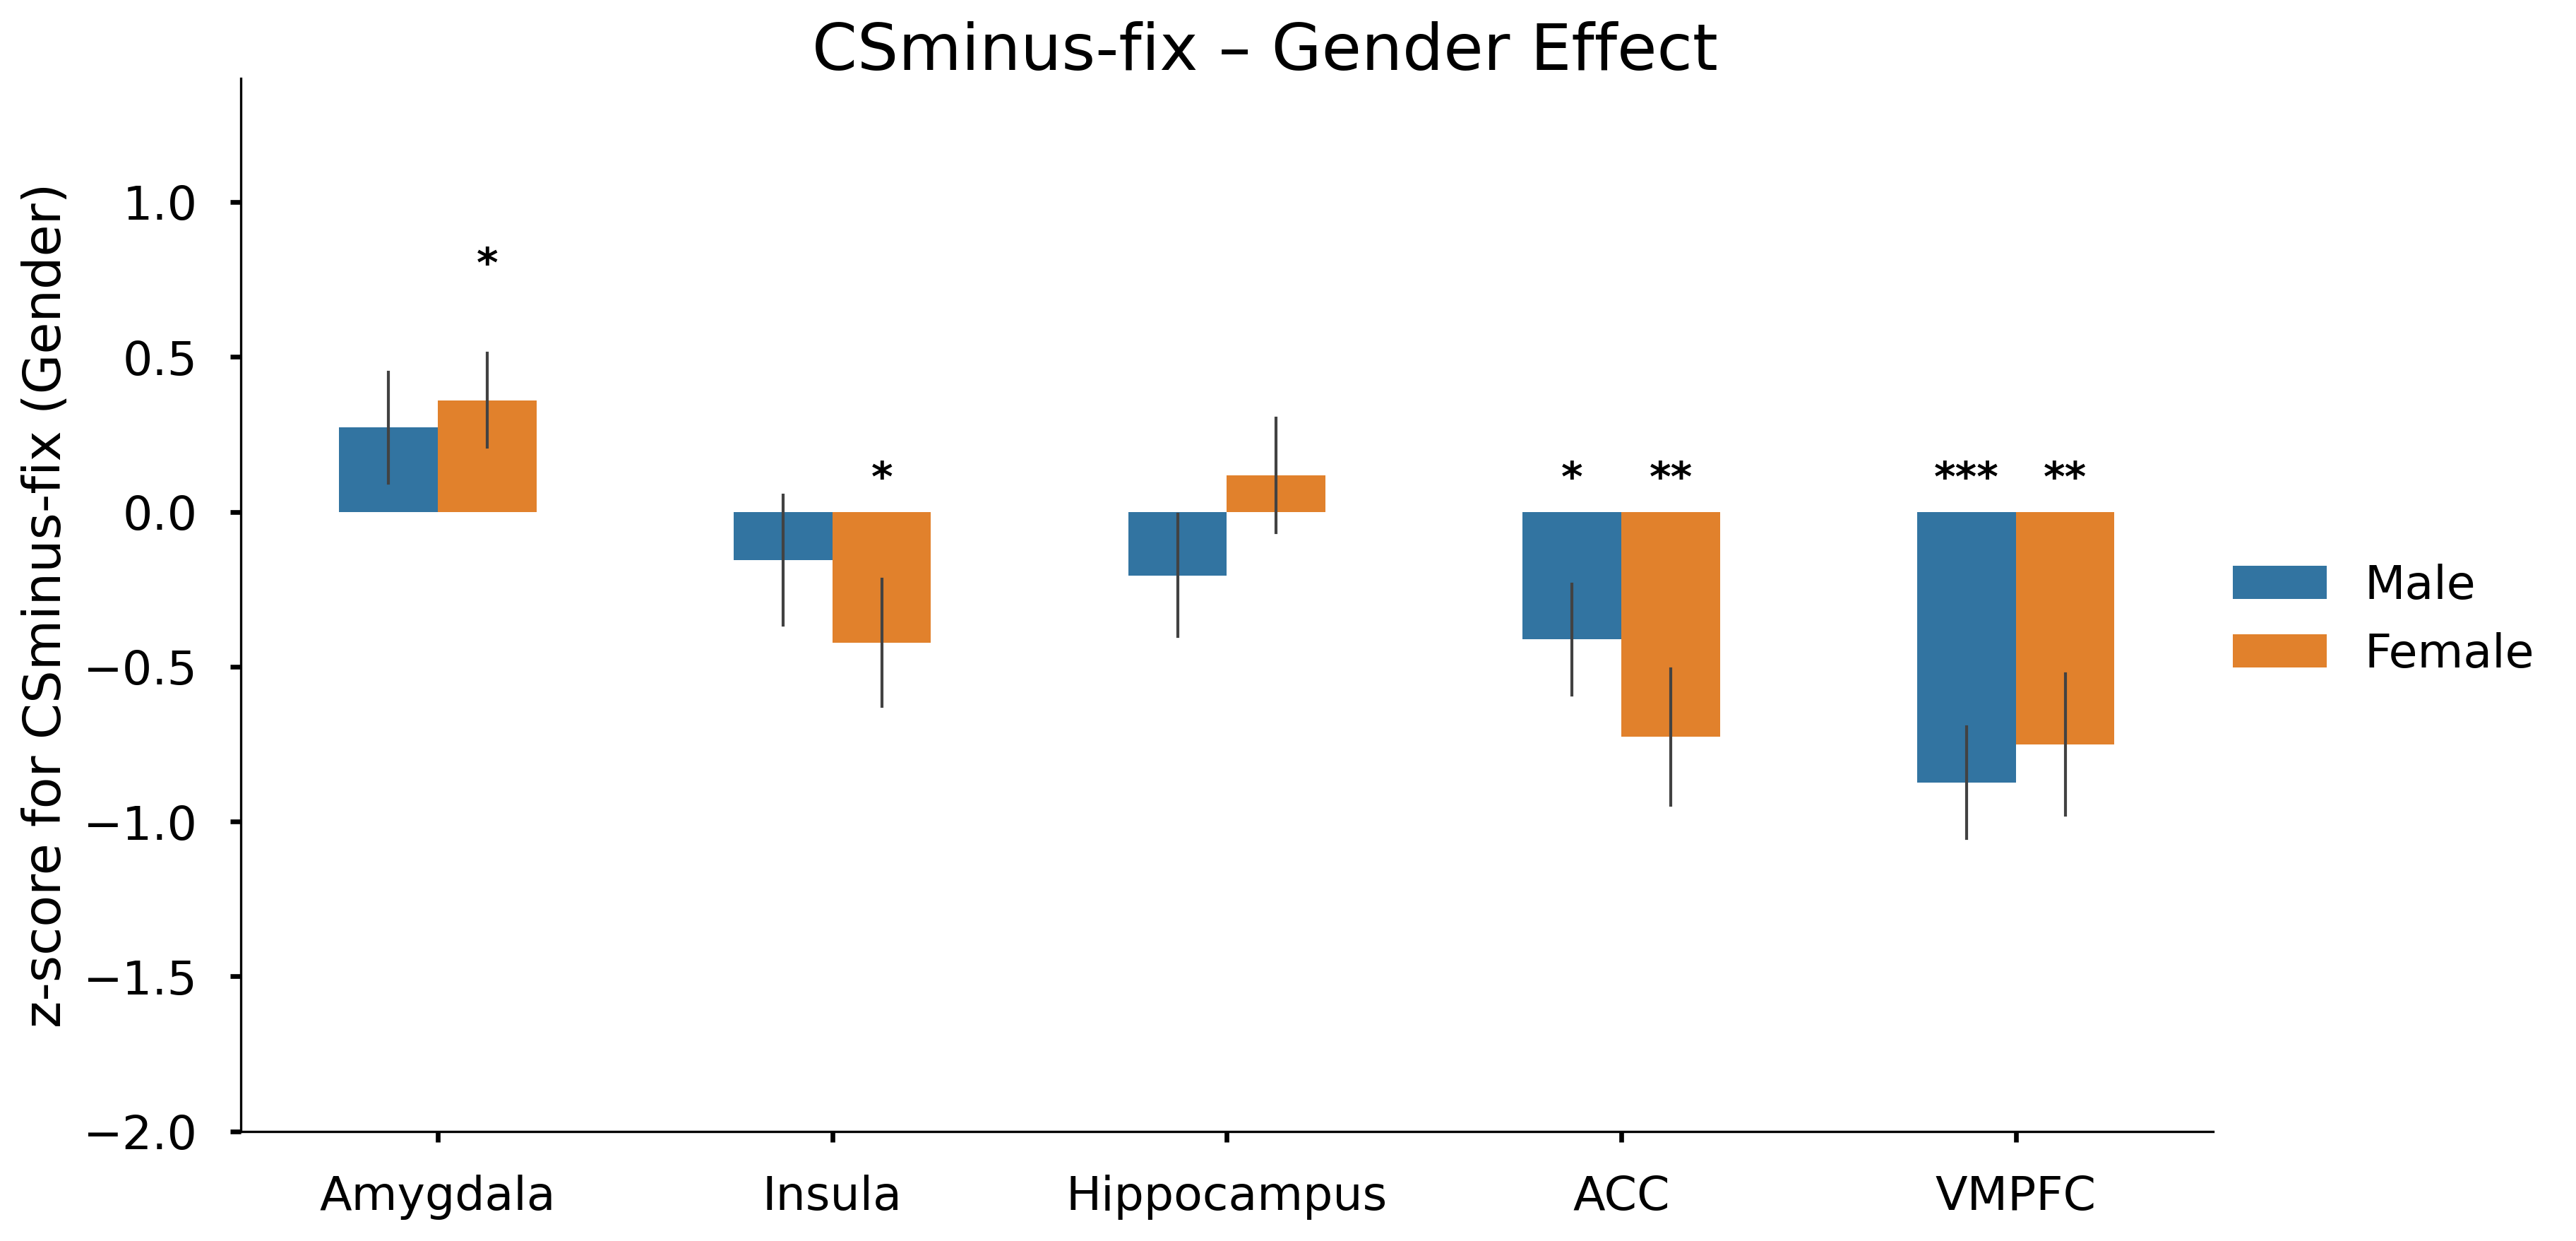

In [ ]:
# ---------------------------------------------------------
# 3️⃣ Gender main effect
# ---------------------------------------------------------
for contrast in contrast_list:
    print(f"\n===== Gender main effect: {contrast} =====")
    df = df_all.loc[(df_all['Contrast'] == contrast) & (df_all['Drug'] == 'Placebo') & (df_all['Phase'] == 'phase2')]

    g = sns.catplot(
        x='ROI', y='Z_score', hue='Gender',
        order=ROI_list, kind='bar', errorbar='se', height=6, aspect=1.8, width=0.5, 
        err_kws={'linewidth': 1},
        data=df
    )

    ax = g.ax
    add_sig_stars(ax, df, ROI_list, get_matching_model_terms(model, "Gender")[0])

    g.set_axis_labels('', f'z-score for {contrast} (Gender)')
    g.set(ylim=(-2, 1.4))
    g.legend.set_title('')
    g.figure.suptitle(f'{contrast} – Gender Effect', fontsize=22, y=1.02)
    g.figure.set_dpi(300)
    plt.savefig(f'{plot_dir}/{contrast}_Gender_sig.png', bbox_inches='tight')
    plt.show()


===== Group × Gender interaction: CSR-CSS =====

Model results (Z_score ~ Group * Gender + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]:Gender[T.Female]                            0.601     1.30    95    0.198      
Insula          Group[T.HC]:Gender[T.Female]                            0.094     0.19    95    0.853      
Hippocampus     Group[T.HC]:Gender[T.Female]                            1.038     2.03    95    0.045     *
ACC             Group[T.HC]:Gender[T.Female]                           -0.212    -0.42    95    0.675      
VMPFC           Group[T.HC]:Gender[T.Female]                           -0.058    -0.10    95    0.917      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY INTERACTION LEVEL (Group × Ge

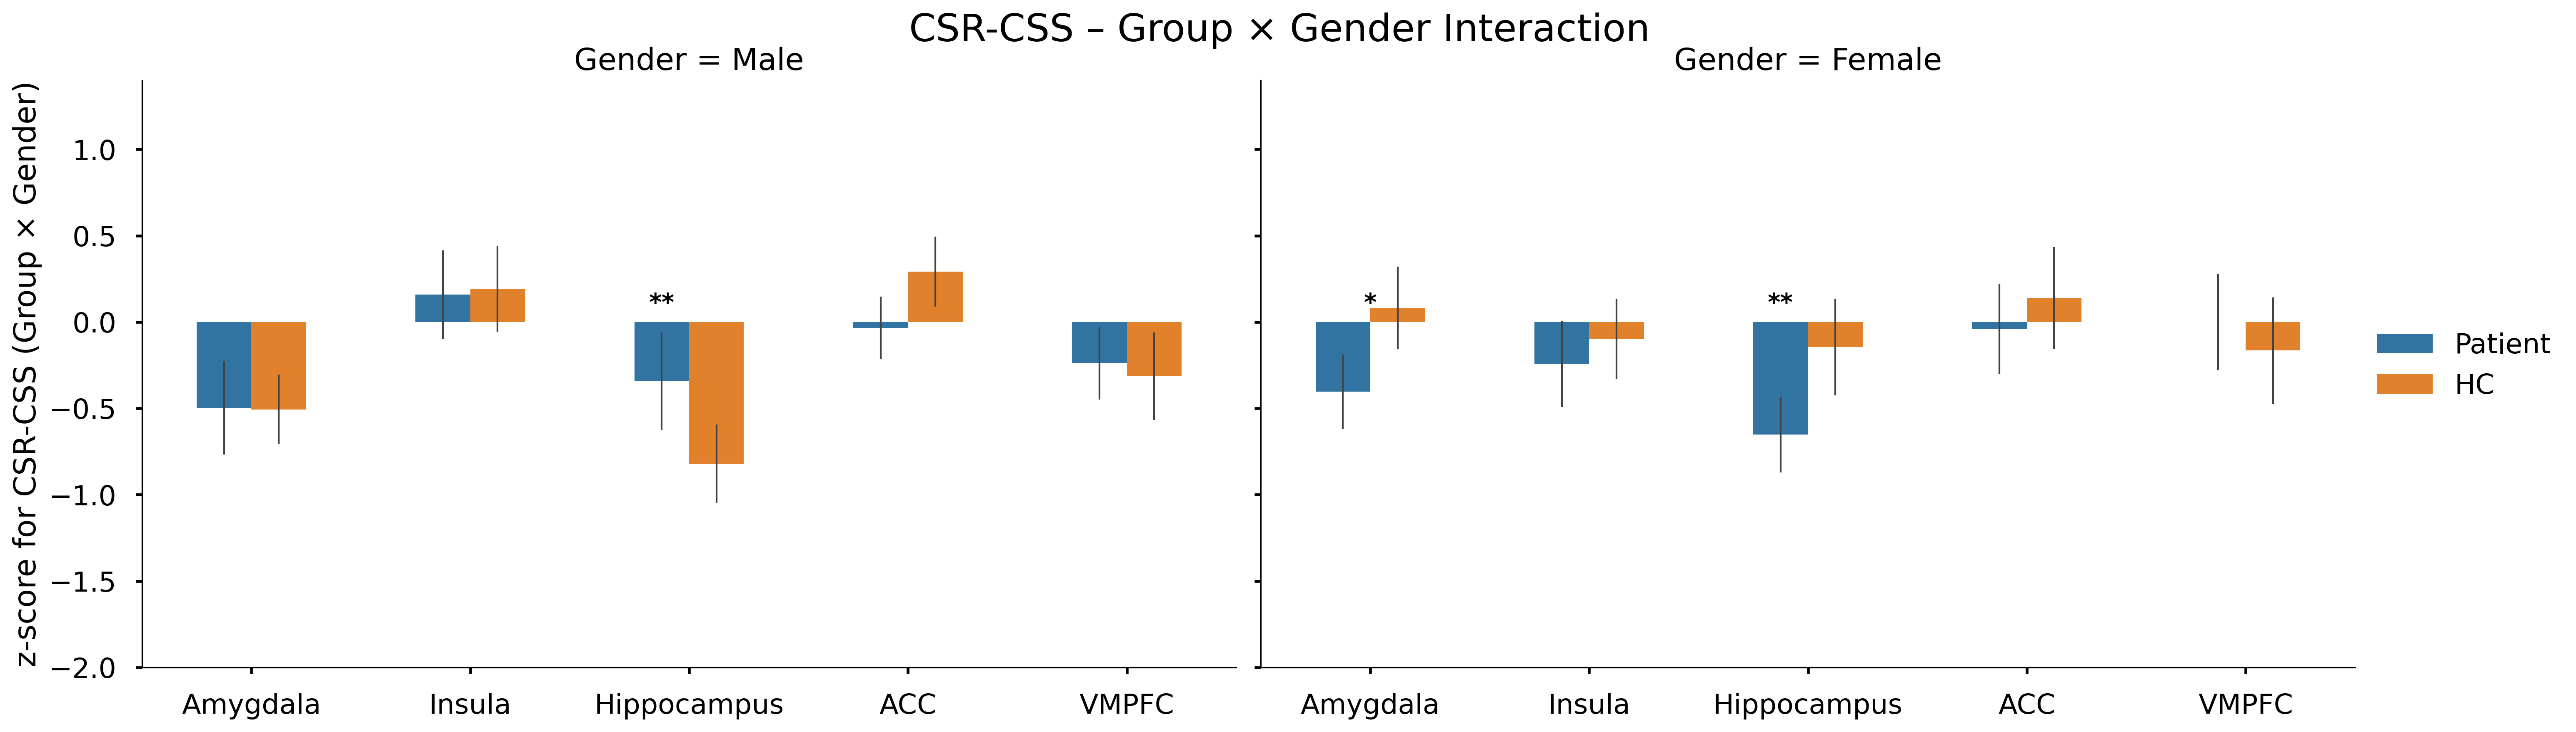


=== Lineplot significance check for Group[T.HC]:Gender[T.Female] ===
Model formula: Z_score ~ Group * Gender + guess
ROI                p-value   Sig
-----------------------------------
Amygdala            0.1977      
Insula              0.8530      
Hippocampus         0.0449     *
ACC                 0.6750      
VMPFC               0.9170      
-----------------------------------


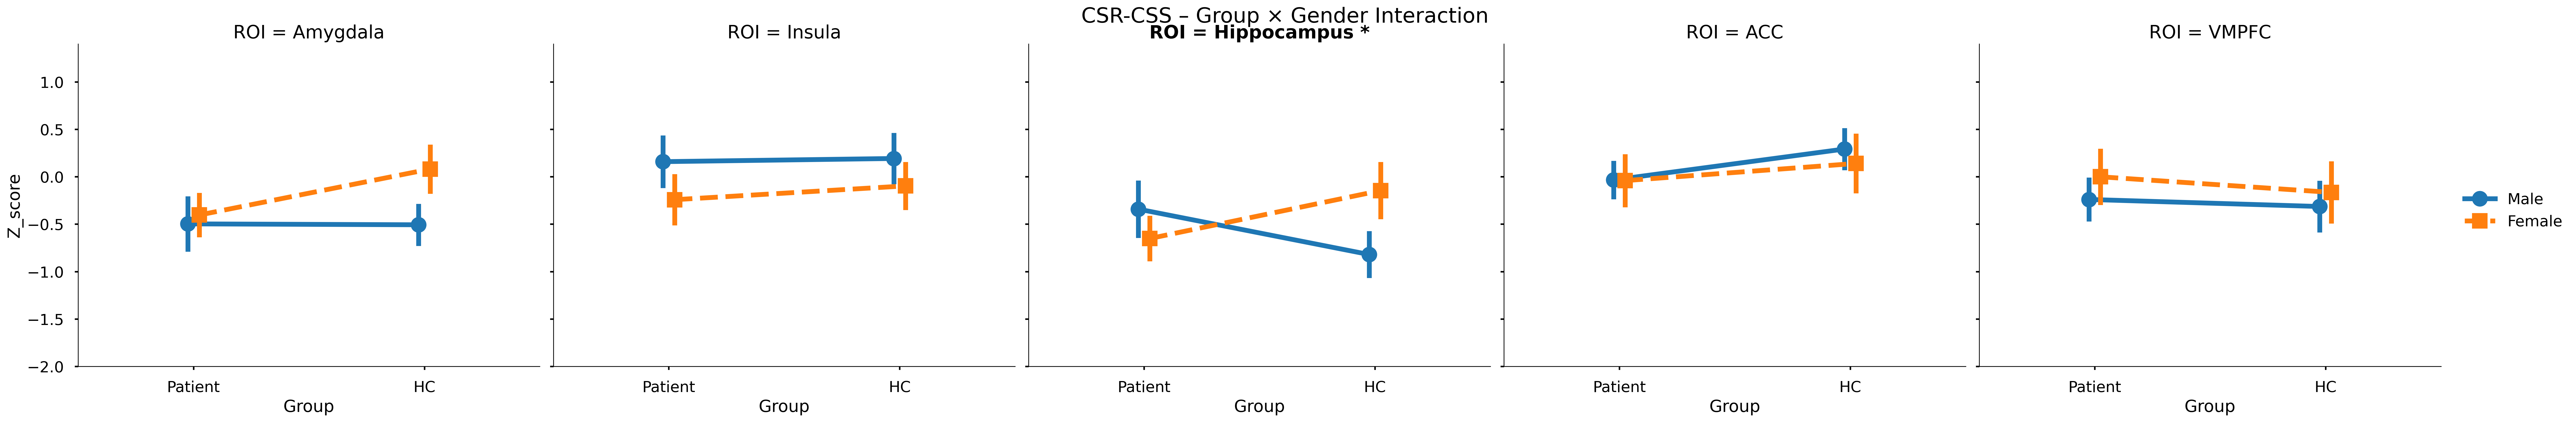


===== Group × Gender interaction: CSR-CS- =====

Model results (Z_score ~ Group * Gender + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]:Gender[T.Female]                            0.581     1.24    95    0.217      
Insula          Group[T.HC]:Gender[T.Female]                           -0.582    -0.99    95    0.325      
Hippocampus     Group[T.HC]:Gender[T.Female]                            1.087     1.80    95    0.076      
ACC             Group[T.HC]:Gender[T.Female]                           -0.355    -0.59    95    0.560      
VMPFC           Group[T.HC]:Gender[T.Female]                            0.307     0.48    95    0.631      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY INTERACTION LEVEL (Group × Ge

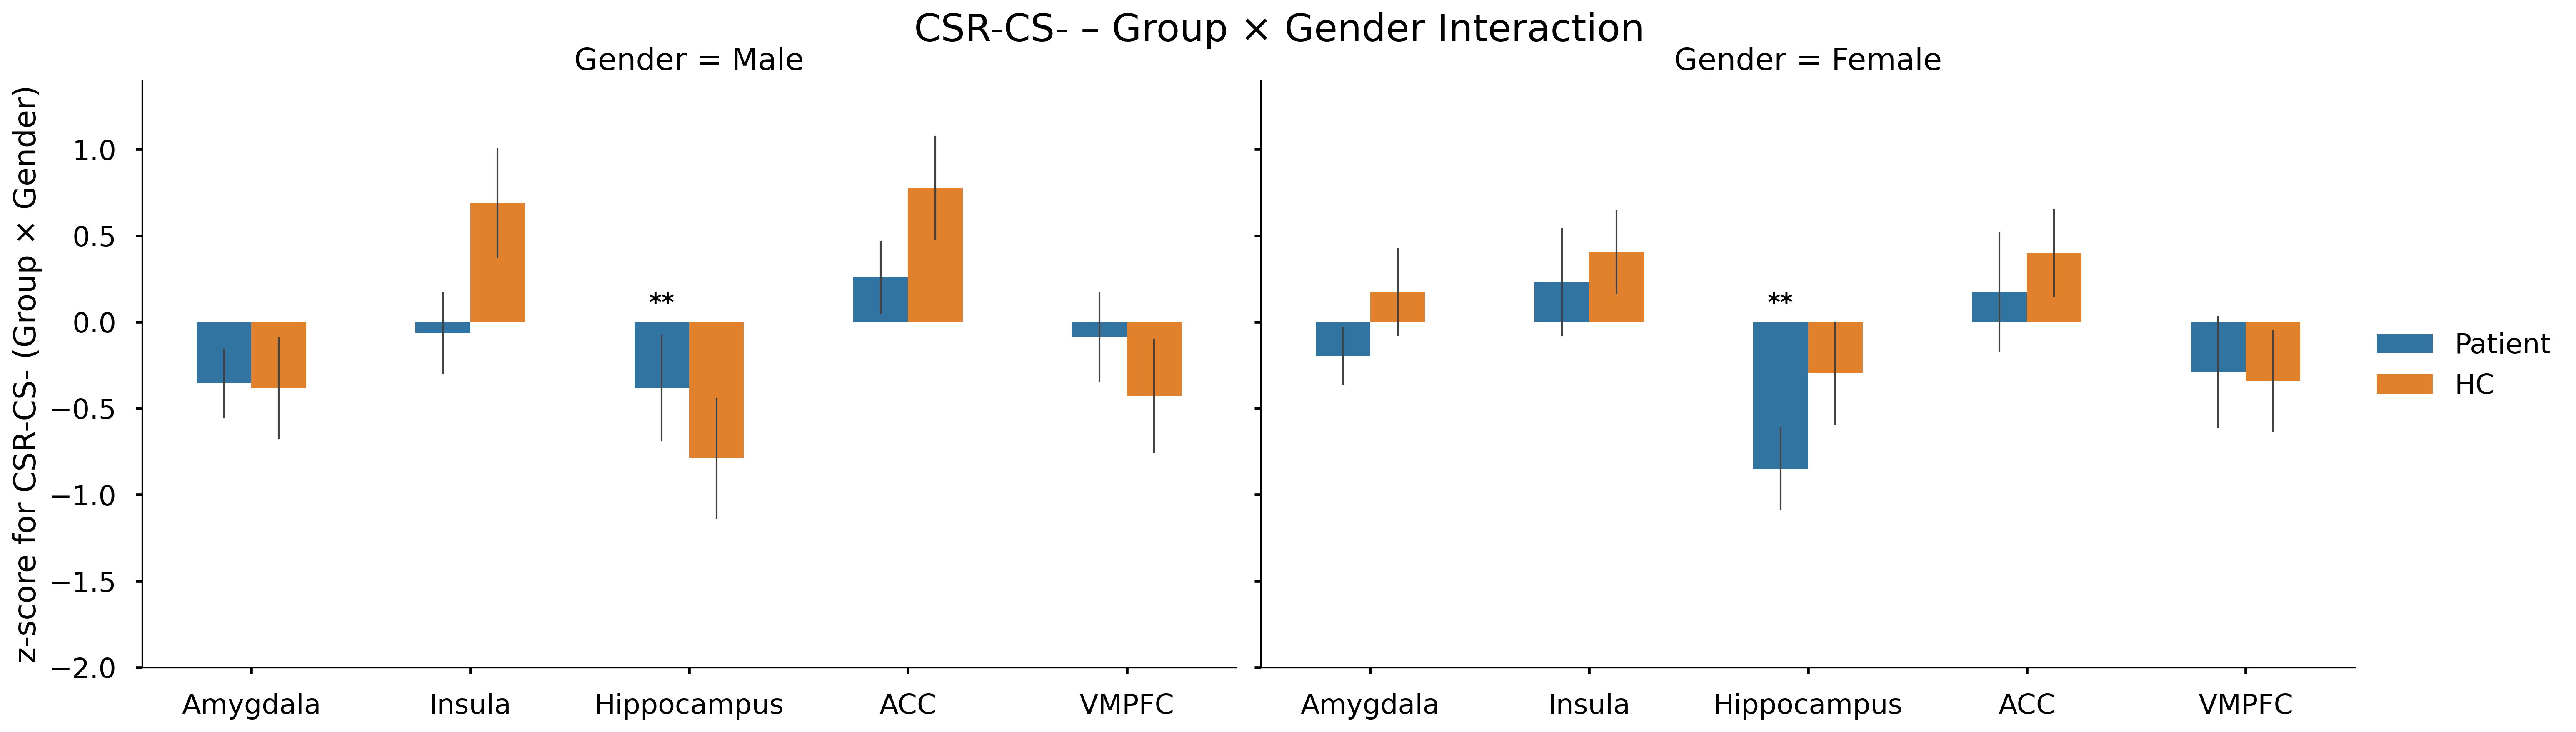


=== Lineplot significance check for Group[T.HC]:Gender[T.Female] ===
Model formula: Z_score ~ Group * Gender + guess
ROI                p-value   Sig
-----------------------------------
Amygdala            0.2167      
Insula              0.3247      
Hippocampus         0.0756      
ACC                 0.5596      
VMPFC               0.6307      
-----------------------------------


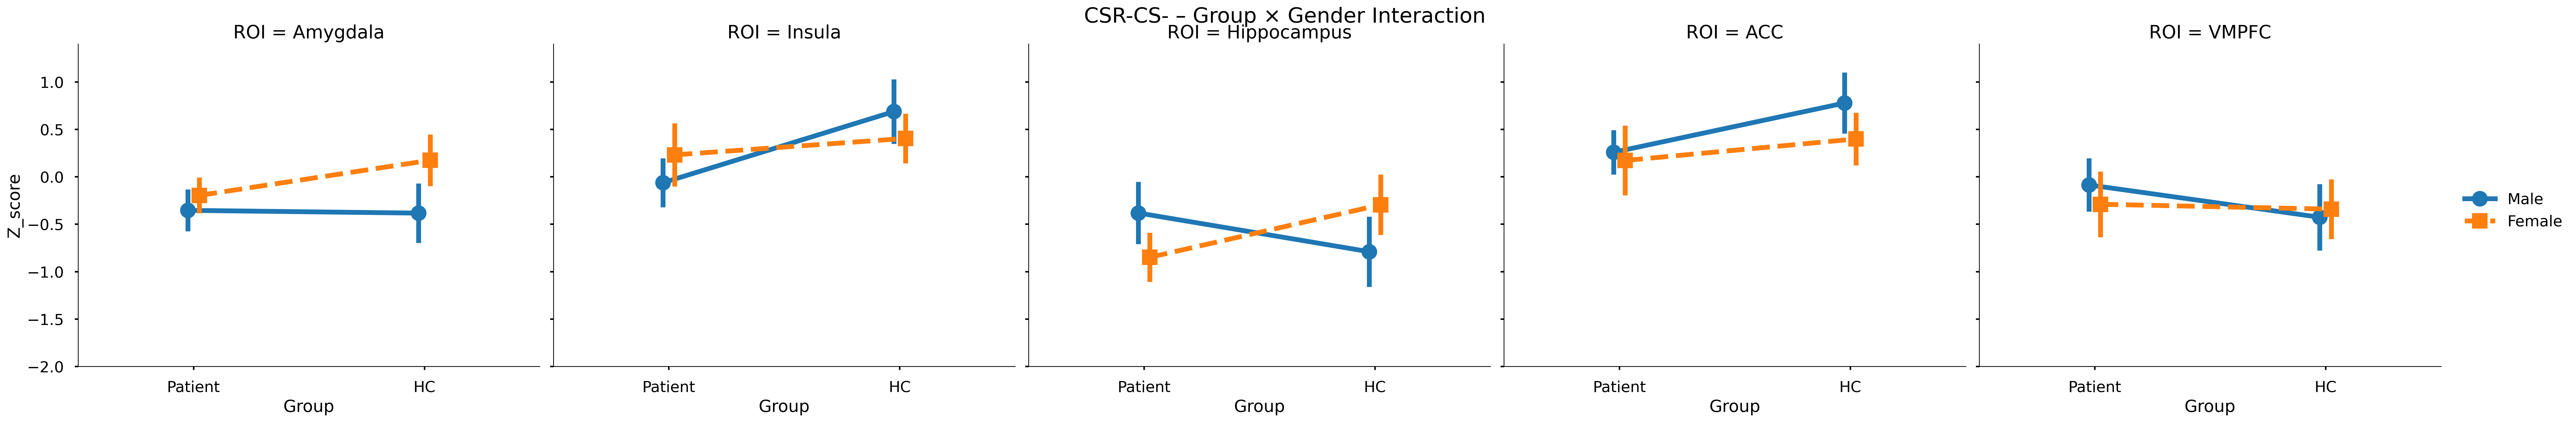


===== Group × Gender interaction: CSS-CS- =====

Model results (Z_score ~ Group * Gender + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]:Gender[T.Female]                           -0.077    -0.17    95    0.863      
Insula          Group[T.HC]:Gender[T.Female]                           -0.656    -1.17    95    0.247      
Hippocampus     Group[T.HC]:Gender[T.Female]                           -0.055    -0.11    95    0.910      
ACC             Group[T.HC]:Gender[T.Female]                           -0.109    -0.19    95    0.848      
VMPFC           Group[T.HC]:Gender[T.Female]                            0.378     0.67    95    0.504      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY INTERACTION LEVEL (Group × Ge

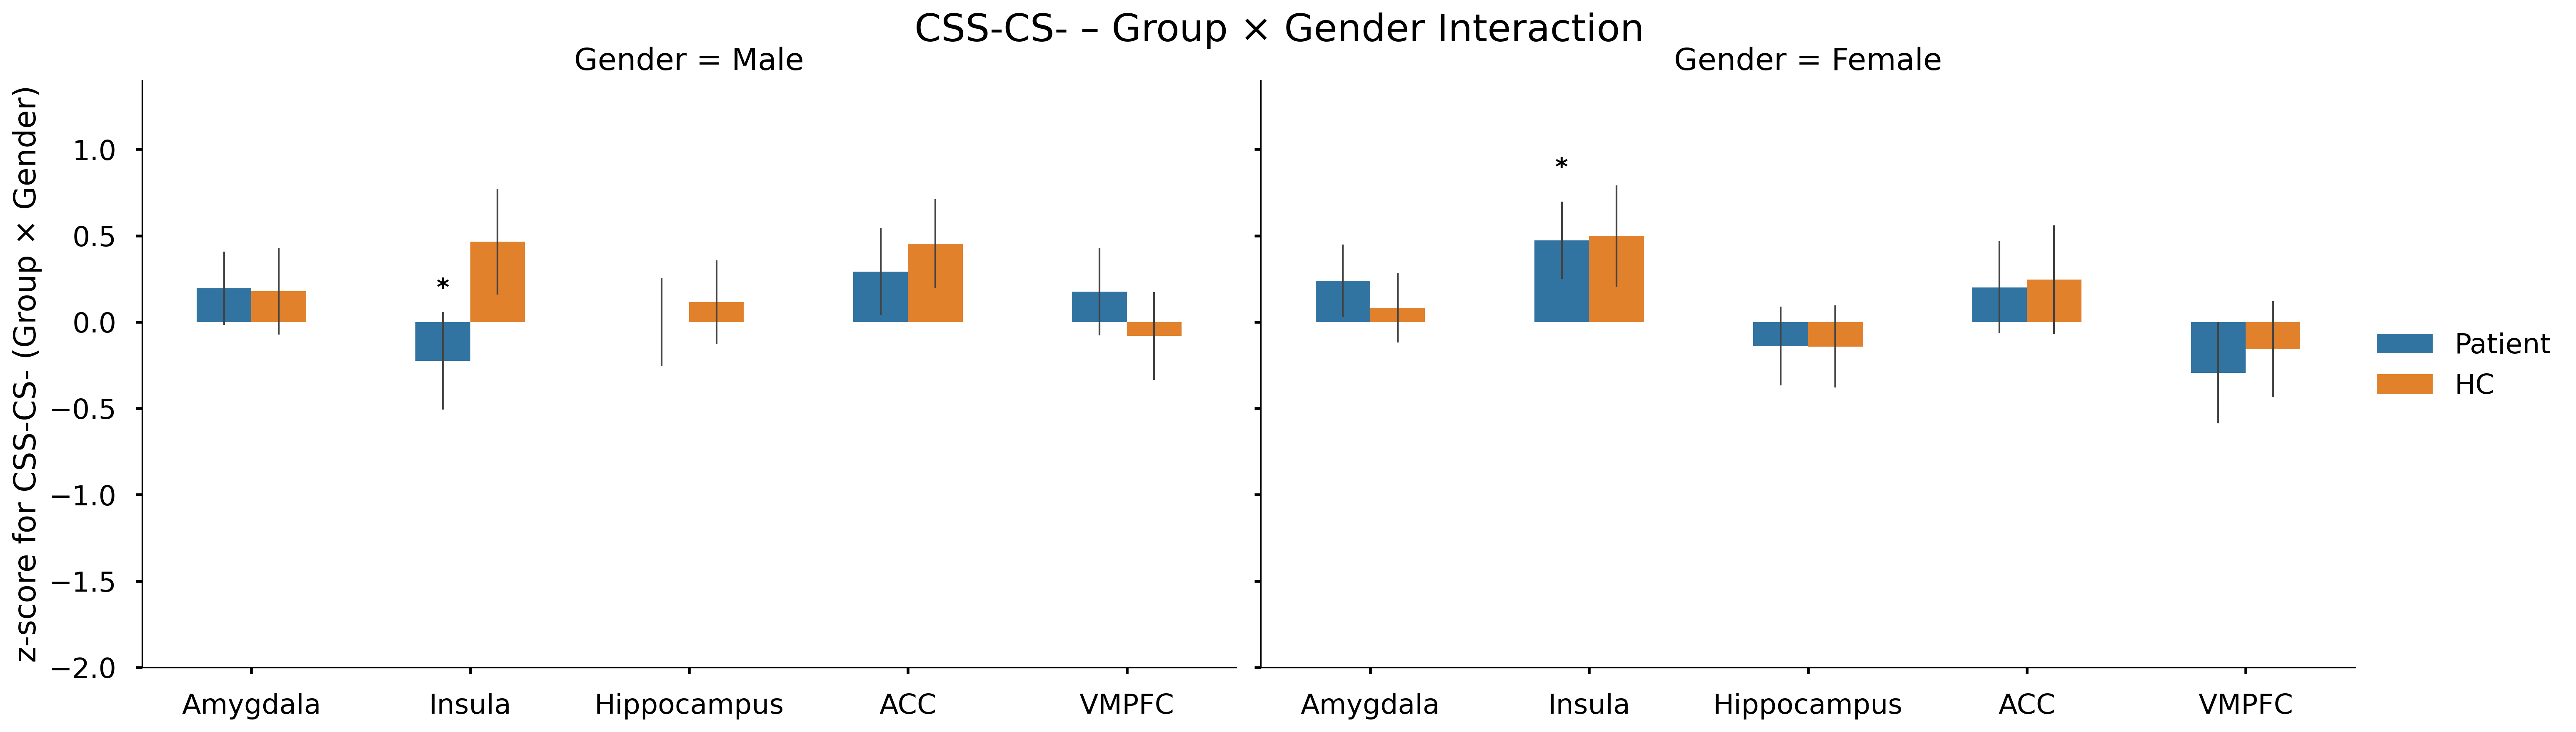


=== Lineplot significance check for Group[T.HC]:Gender[T.Female] ===
Model formula: Z_score ~ Group * Gender + guess
ROI                p-value   Sig
-----------------------------------
Amygdala            0.8632      
Insula              0.2468      
Hippocampus         0.9098      
ACC                 0.8484      
VMPFC               0.5039      
-----------------------------------


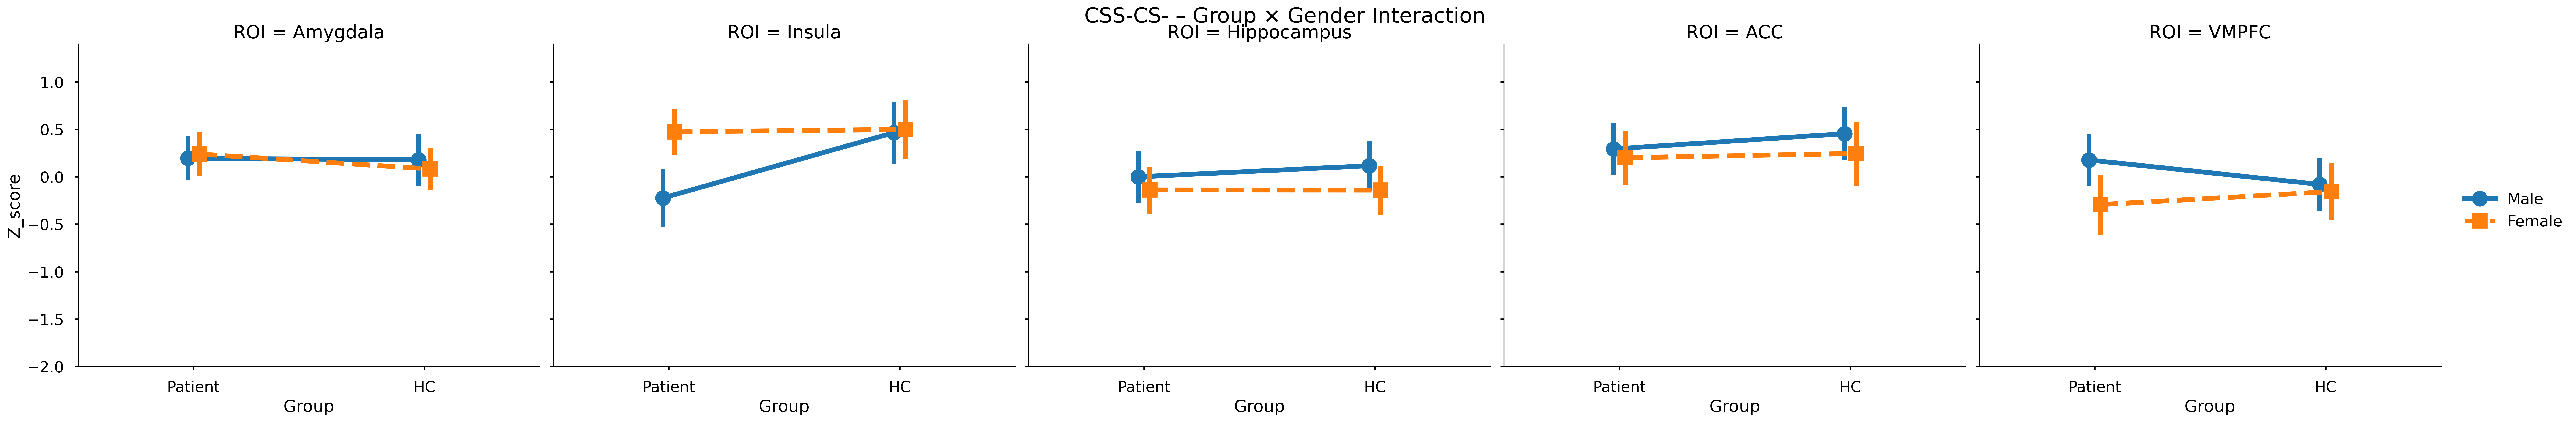


===== Group × Gender interaction: CSR-fix =====

Model results (Z_score ~ Group * Gender + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]:Gender[T.Female]                            0.877     1.76    95    0.081      
Insula          Group[T.HC]:Gender[T.Female]                           -0.161    -0.33    95    0.745      
Hippocampus     Group[T.HC]:Gender[T.Female]                            1.155     2.01    95    0.047     *
ACC             Group[T.HC]:Gender[T.Female]                           -0.414    -0.70    95    0.488      
VMPFC           Group[T.HC]:Gender[T.Female]                            0.305     0.48    95    0.630      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY INTERACTION LEVEL (Group × Ge

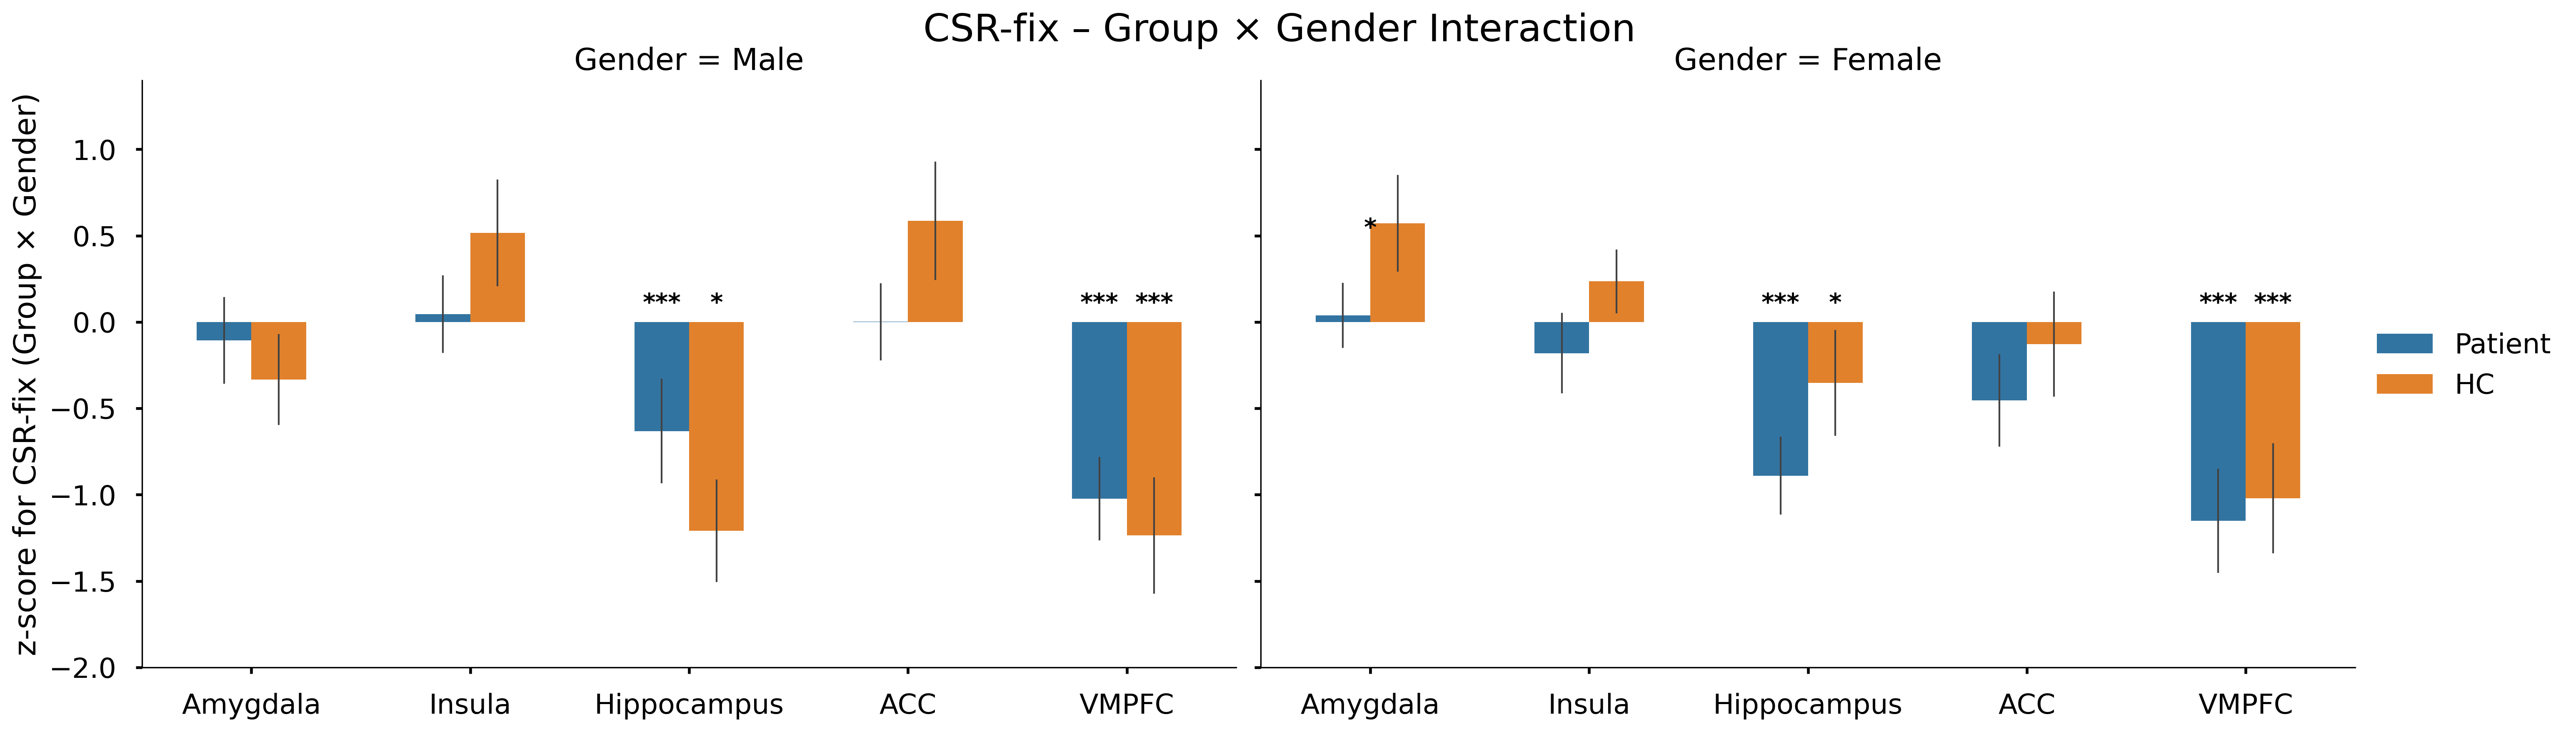


=== Lineplot significance check for Group[T.HC]:Gender[T.Female] ===
Model formula: Z_score ~ Group * Gender + guess
ROI                p-value   Sig
-----------------------------------
Amygdala            0.0809      
Insula              0.7450      
Hippocampus         0.0469     *
ACC                 0.4884      
VMPFC               0.6305      
-----------------------------------


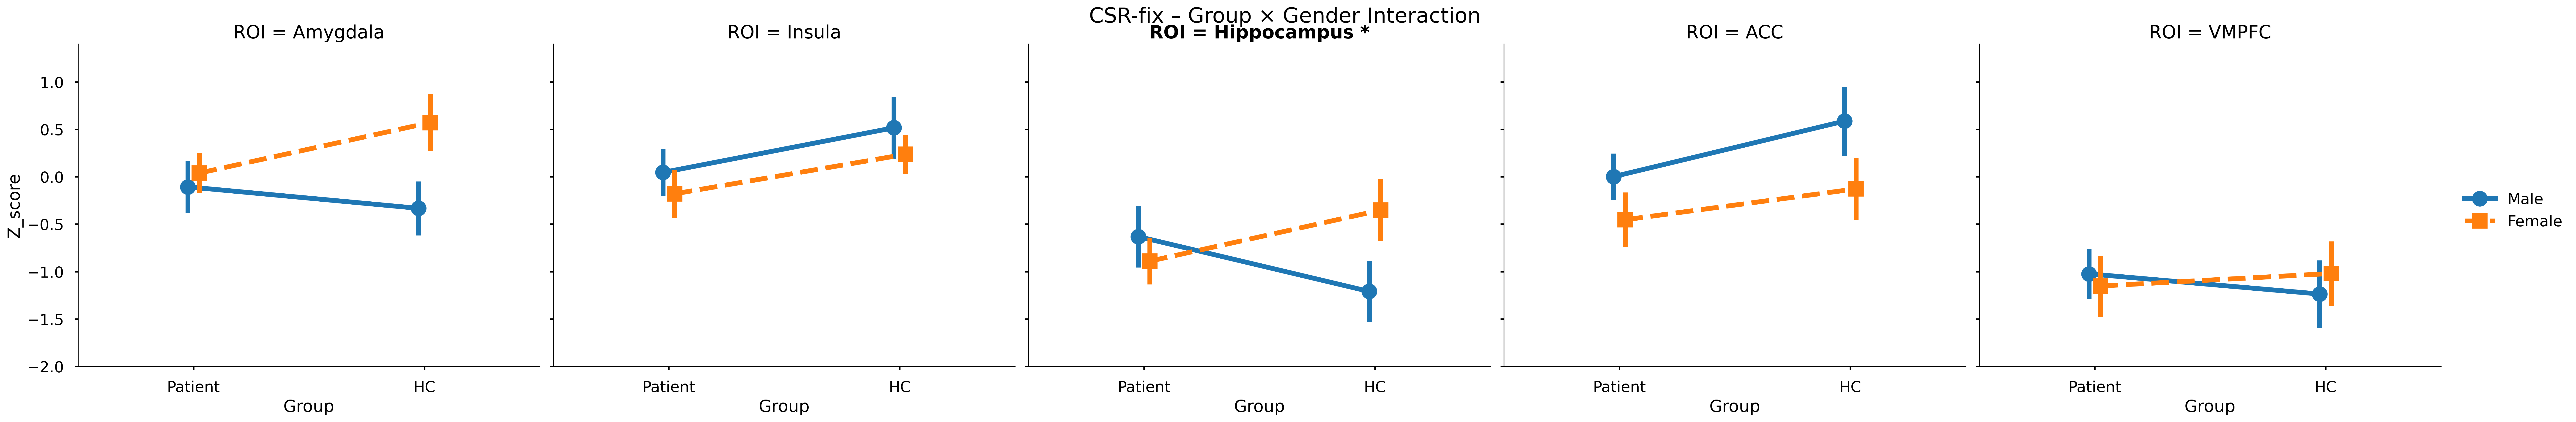


===== Group × Gender interaction: CSS-fix =====

Model results (Z_score ~ Group * Gender + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]:Gender[T.Female]                            0.037     0.08    95    0.937      
Insula          Group[T.HC]:Gender[T.Female]                           -0.273    -0.53    95    0.599      
Hippocampus     Group[T.HC]:Gender[T.Female]                           -0.271    -0.57    95    0.572      
ACC             Group[T.HC]:Gender[T.Female]                           -0.105    -0.19    95    0.846      
VMPFC           Group[T.HC]:Gender[T.Female]                            0.383     0.67    95    0.507      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY INTERACTION LEVEL (Group × Ge

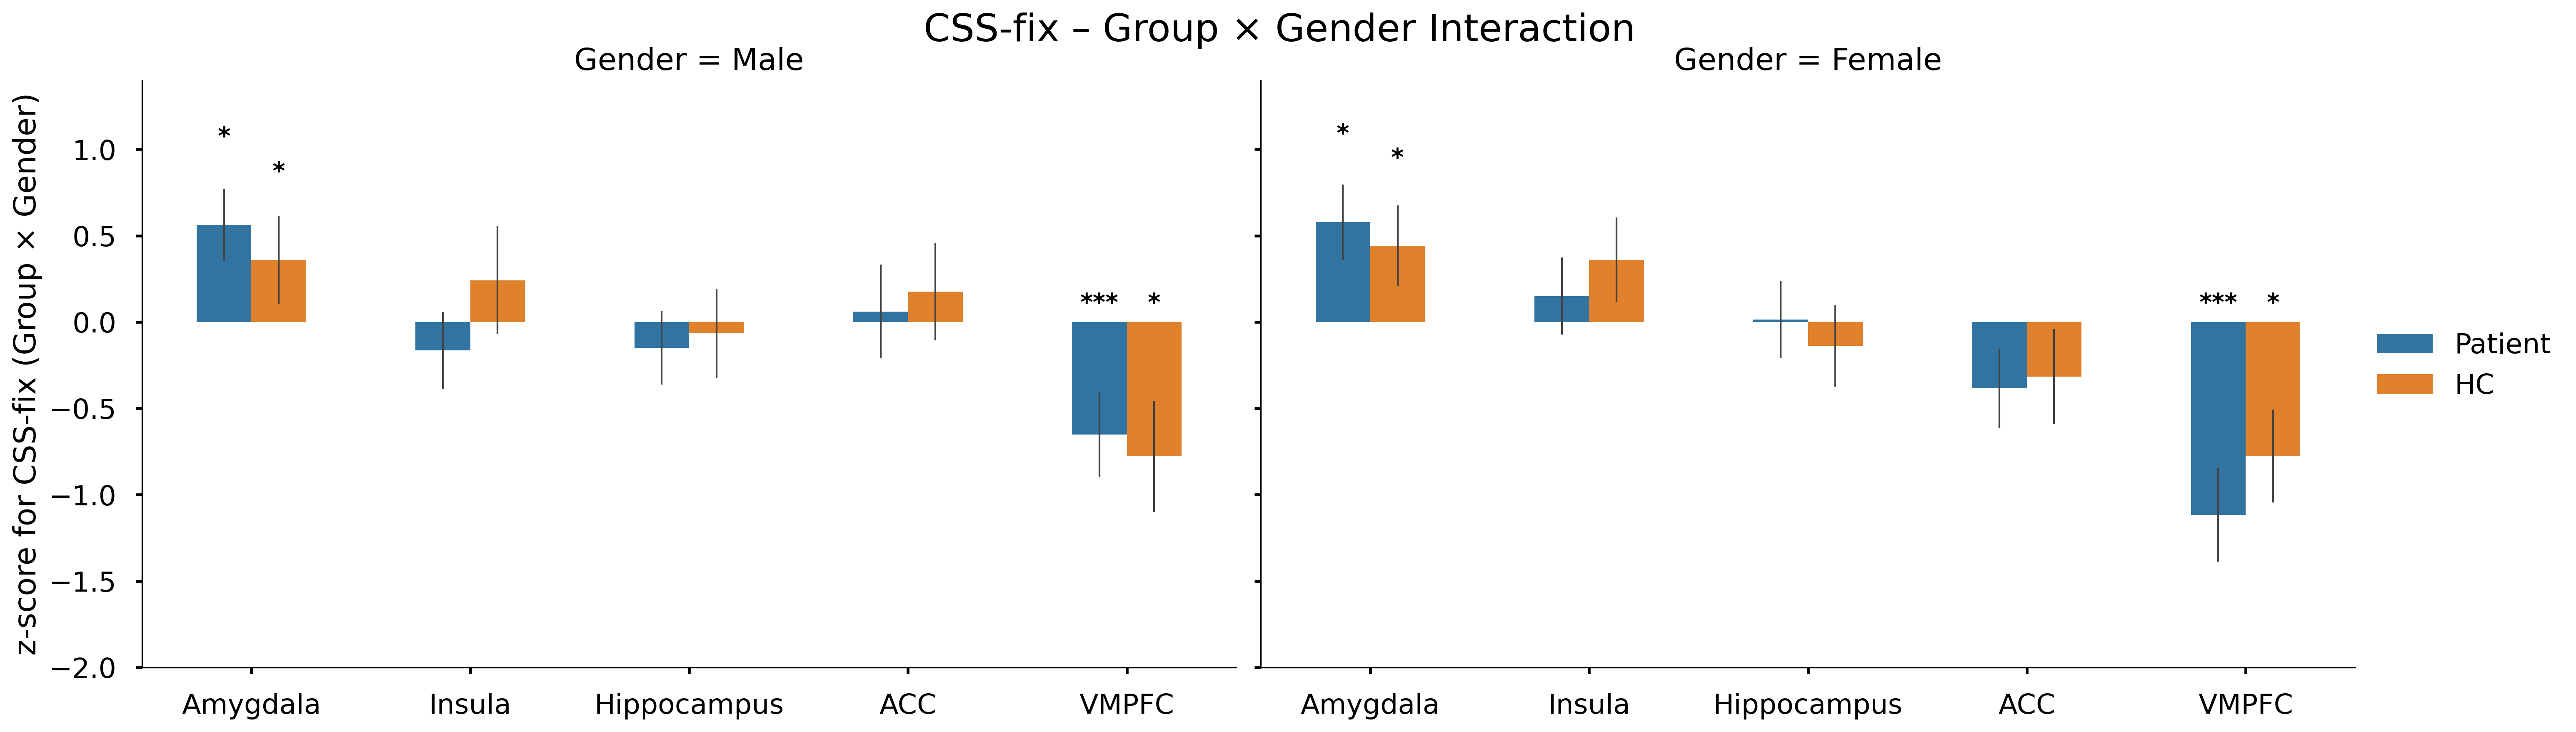


=== Lineplot significance check for Group[T.HC]:Gender[T.Female] ===
Model formula: Z_score ~ Group * Gender + guess
ROI                p-value   Sig
-----------------------------------
Amygdala            0.9370      
Insula              0.5994      
Hippocampus         0.5717      
ACC                 0.8460      
VMPFC               0.5071      
-----------------------------------


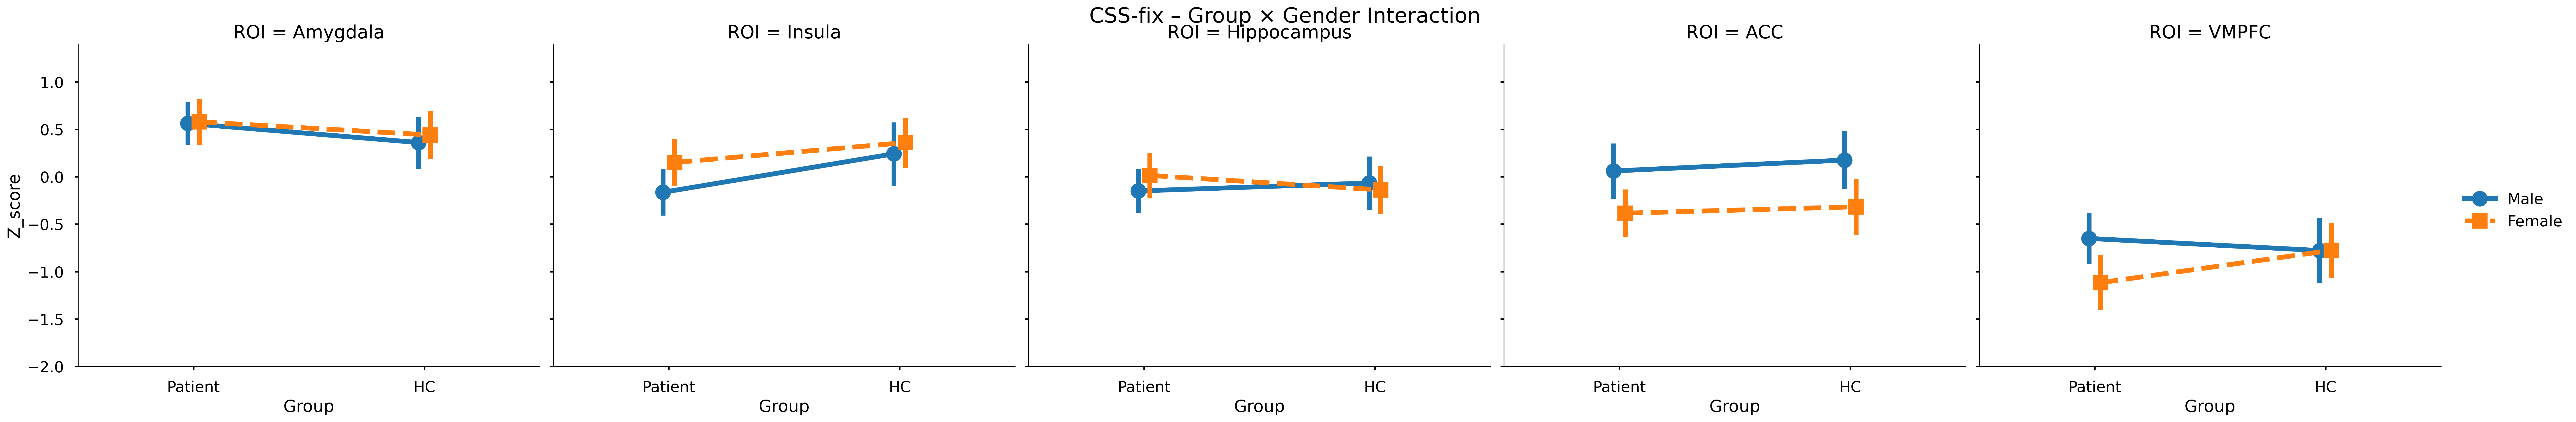


===== Group × Gender interaction: CSminus-fix =====

Model results (Z_score ~ Group * Gender + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]:Gender[T.Female]                            0.148     0.31    95    0.759      
Insula          Group[T.HC]:Gender[T.Female]                            0.638     1.05    95    0.297      
Hippocampus     Group[T.HC]:Gender[T.Female]                           -0.250    -0.45    95    0.657      
ACC             Group[T.HC]:Gender[T.Female]                            0.053     0.09    95    0.931      
VMPFC           Group[T.HC]:Gender[T.Female]                           -0.123    -0.20    95    0.844      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY INTERACTION LEVEL (Group 

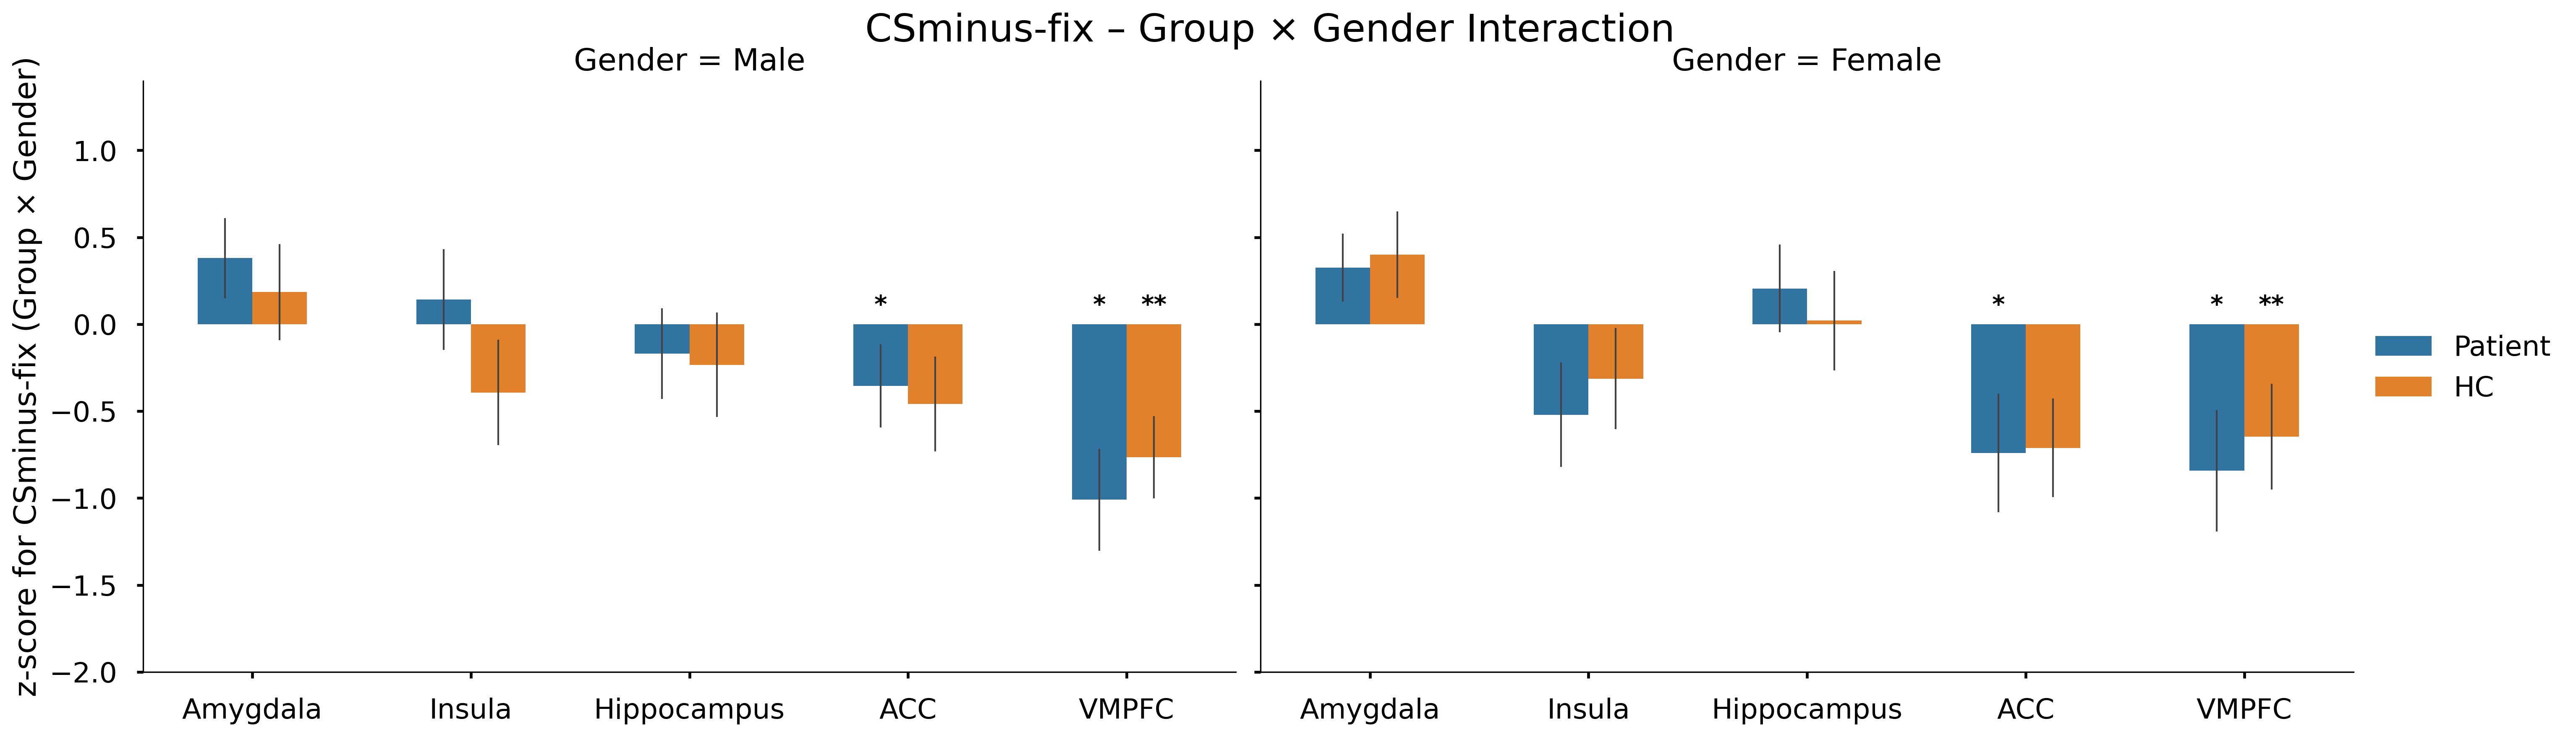


=== Lineplot significance check for Group[T.HC]:Gender[T.Female] ===
Model formula: Z_score ~ Group * Gender + guess
ROI                p-value   Sig
-----------------------------------
Amygdala            0.7591      
Insula              0.2971      
Hippocampus         0.6573      
ACC                 0.9306      
VMPFC               0.8444      
-----------------------------------


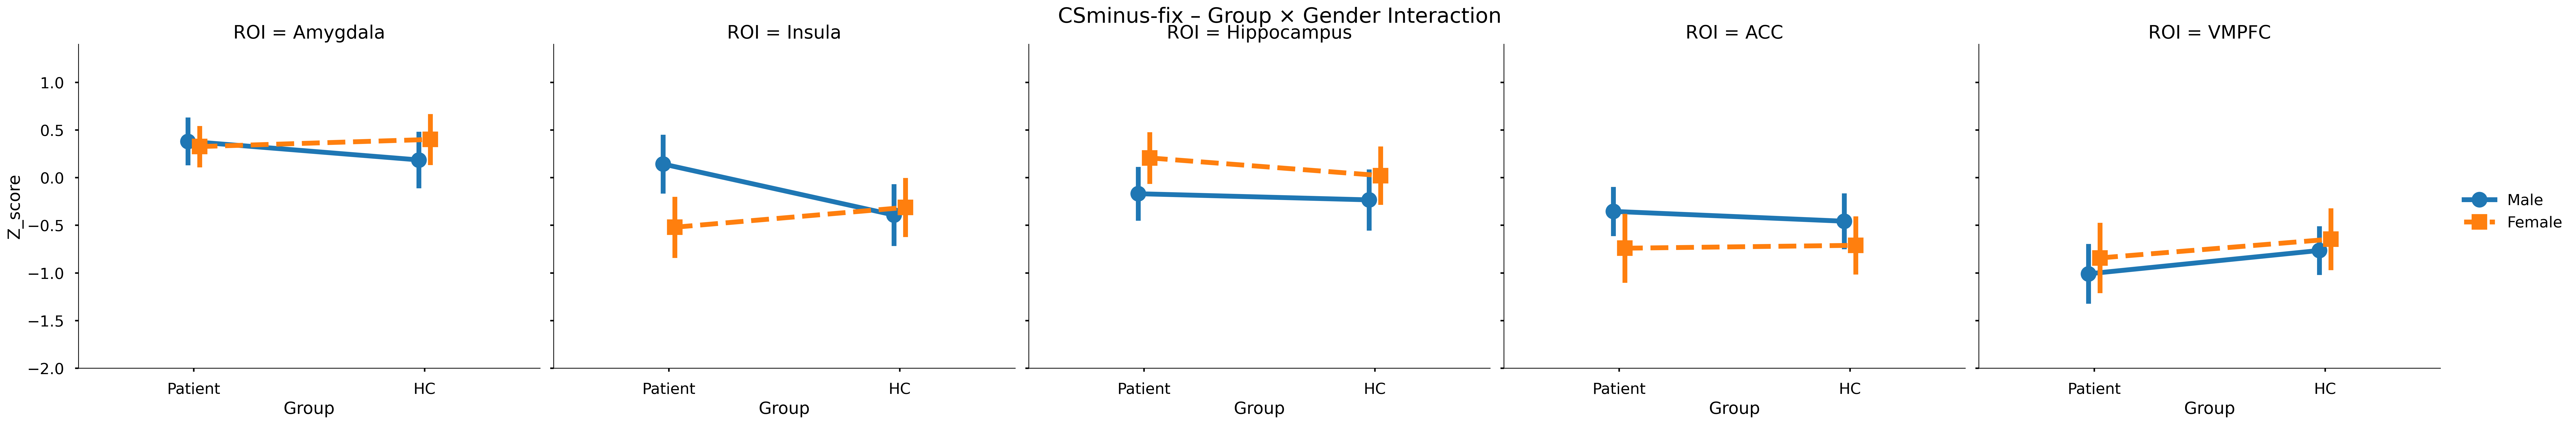

In [ ]:
interaction_terms = get_matching_model_terms(model, "two_way")

for term in interaction_terms:
    var1, var2 = extract_factors_from_term(term)
    for contrast in contrast_list:
        print(f"\n===== {var1} × {var2} interaction: {contrast} =====")
        df = df_all.loc[(df_all['Contrast'] == contrast) & (df_all['Drug'] == 'Placebo') & (df_all['Phase'] == 'phase2')]

        g = sns.catplot(
            x='ROI', y='Z_score', hue=var1, col=var2,
            order=ROI_list,
            kind='bar', errorbar='se',
            height=6, aspect=1.6, width=0.5,
            err_kws={'linewidth': 1},
            data=df
        )

        for ax in g.axes.flat:
            add_sig_stars(ax, df, ROI_list, term)

        g.set_axis_labels('', f'z-score for {contrast} ({var1} × {var2})')
        g.set(ylim=(-2, 1.4))
        g.legend.set_title('')
        g.figure.suptitle(f'{contrast} – {var1} × {var2} Interaction', fontsize=22, y=1.02)
        g.figure.set_dpi(300)
        plt.savefig(f'{plot_dir}/{contrast}_{var1}_{var2}_interaction_sig.png', bbox_inches='tight')
        plt.show()

        #line plots
        g = sns.catplot(
            data=df,
            x=var1, y='Z_score', hue=var2,
            col='ROI',
            kind='point',         # line plot (mean + SE)
            errorbar='se',        # ✅ correct for seaborn ≥0.12
            dodge=True,
            markers=['o', 's'],
            linestyles=['-', '--'],
            height=6, aspect=1.2
        )
        add_sig_stars_lineplot_interaction(
            g.axes, df, ROI_list, term
        )
        #g.set_axis_labels('', f'z-score for {contrast} ({var1} × {var2})')
        g.set(ylim=(-2, 1.4))
        g.legend.set_title('')
        g.figure.suptitle(f'{contrast} – {var1} × {var2} Interaction', fontsize=22, y=1.02)
        g.figure.set_dpi(300)
        plt.savefig(f'{plot_dir}/line_{contrast}_{var1}_{var2}_interaction_sig.png', bbox_inches='tight')
        plt.show()

In [ ]:

formula = "Z_score ~ Group * Gender + guess"

for contrast in contrast_list:
        df = df_all.loc[(df_all['Contrast'] == contrast) & (df_all['Drug'] == 'Placebo') & (df_all['Phase'] == 'phase2')]

        print(f"\nModel results ({formula}) in {contrast}")
        print(f"{'ROI':<15} {'Variable':<50} {'β':>10} {'t':>8} {'df':>5} {'p':>8} {'Sig':>5}")
        print("-" * 100)

        # === Table 1: Model results ===
        for i, roi in enumerate(ROI_list):
            df_roi = df[df["ROI"] == roi]
            if len(df_roi) < 4:
                continue
            model = smf.ols(formula, data=df_roi).fit()
            dfree = int(model.df_resid)

            # Extract and print all terms except intercept
            for term in model.params.index:
                if term.lower() == "intercept":
                    continue

                beta = model.params[term]
                tval = model.tvalues[term]
                pval = model.pvalues[term]
                star = significance_marker(pval)

                print(f"{roi:<15} {term:<50} {beta:>10.3f} {tval:>8.2f} "
                    f"{dfree:>5} {pval:>10.4f} {star:>5}")

        print("-" * 100)
    


Model results (Z_score ~ Group * Gender + guess) in CSR-CSS
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                            -0.058    -0.17    95     0.8656      
Amygdala        Gender[T.Female]                                        0.024     0.07    95     0.9415      
Amygdala        guess[T.1.0]                                           -0.267    -1.12    95     0.2653      
Amygdala        Group[T.HC]:Gender[T.Female]                            0.601     1.30    95     0.1977      
Insula          Group[T.HC]                                             0.042     0.11    95     0.9110      
Insula          Gender[T.Female]                                       -0.389    -1.08    95     0.2847      
Insula          guess[T.1.0]                                          